# Predict Bike Sharing Demand with AutoGluon Template

## Project: Predict Bike Sharing Demand with AutoGluon

### Install packages

In [2]:
!pip install -U pip
!pip install -U setuptools wheel
!pip install -U "mxnet<2.0.0" bokeh==2.0.1
!pip install autogluon --no-cache-dir
# Without --no-cache-dir, smaller aws instances may have trouble installing

  Using cached pip-22.3-py3-none-any.whl (2.1 MB)
  Attempting uninstall: pip
    Found existing installation: pip 21.3.1
    Uninstalling pip-21.3.1:
      Successfully uninstalled pip-21.3.1
  Using cached setuptools-65.5.0-py3-none-any.whl (1.2 MB)
  Using cached wheel-0.37.1-py2.py3-none-any.whl (35 kB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 59.4.0
    Uninstalling setuptools-59.4.0:
      Successfully uninstalled setuptools-59.4.0
  Using cached mxnet-1.9.1-py3-none-manylinux2014_x86_64.whl (49.1 MB)
  Using cached bokeh-2.0.1-py3-none-any.whl
  Attempting uninstall: bokeh
    Found existing installation: bokeh 2.4.2
    Uninstalling bokeh-2.4.2:
      Successfully uninstalled bokeh-2.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.8/48.8 kB 94.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.9/61.9 kB 165.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.4/65.4 kB 172.5 MB/s eta 0:00:00
     ━━━━━━━━━

### Setup Kaggle API Key

In [3]:
# create the .kaggle directory and an empty kaggle.json file
# !mkdir -p /root/.kaggle
# !touch /root/.kaggle/kaggle.json
# !chmod 600 /root/.kaggle/kaggle.json

In [4]:
# !more /root/.kaggle/kaggle.json

In [5]:
# Fill in your user name and key from creating the kaggle account and API token file
# import json
# kaggle_username = "jeff93"
# kaggle_key = "30761de14c08905e668a106774fcbdff"

# # Save API token the kaggle.json file
# with open("/root/.kaggle/kaggle.json", "w") as f:
#     f.write(json.dumps({"username": kaggle_username, "key": kaggle_key}))

### Download and explore dataset

In [6]:
!python3 -m pip install kaggle
# Download the dataset, it will be in a .zip file so you'll need to unzip it as well.
# !kaggle competitions download -c bike-sharing-demand
# If you already downloaded it you can use the -o command to overwrite the file
# !unzip -o bike-sharing-demand.zip

  Using cached kaggle-1.5.12-py3-none-any.whl
  Using cached python_slugify-6.1.2-py2.py3-none-any.whl (9.4 kB)
  Using cached text_unidecode-1.3-py2.py3-none-any.whl (78 kB)


# Import Dependencies to start the project

In [200]:
import numpy as np
import pandas as pd

import sklearn
from sklearn.model_selection import train_test_split, GridSearchCV
from scipy.stats import boxcox
from scipy.special import inv_boxcox
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb
from sklearn.preprocessing import StandardScaler

from sklearn.tree import DecisionTreeRegressor
import graphviz
from sklearn.tree import plot_tree

from datetime import datetime 

import autogluon
from autogluon.tabular import TabularPredictor

import matplotlib
from matplotlib import pyplot as plt

import seaborn as sns

In [8]:
# Create the train dataset in pandas by reading the csv
# Set the parsing of the datetime column so you can use some of the `dt` features in pandas later
train = pd.read_csv("./train.csv")
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [9]:
# Simple output of the train dataset to view some of the min/max/varition of the dataset features.
train.describe()

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
count,10886.000000,10886.000000,10886.000000,10886.000000,10886.00000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000,10886.000000
mean,2.506614,0.028569,0.680875,1.418427,20.23086,23.655084,61.886460,12.799395,36.021955,155.552177,191.574132
std,1.116174,0.166599,0.466159,0.633839,7.79159,8.474601,19.245033,8.164537,49.960477,151.039033,181.144454
min,1.000000,0.000000,0.000000,1.000000,0.82000,0.760000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2.000000,0.000000,0.000000,1.000000,13.94000,16.665000,47.000000,7.001500,4.000000,36.000000,42.000000
50%,3.000000,0.000000,1.000000,1.000000,20.50000,24.240000,62.000000,12.998000,17.000000,118.000000,145.000000
75%,4.000000,0.000000,1.000000,2.000000,26.24000,31.060000,77.000000,16.997900,49.000000,222.000000,284.000000
max,4.000000,1.000000,1.000000,4.000000,41.00000,45.455000,100.000000,56.996900,367.000000,886.000000,977.000000


In [10]:
# Create the test pandas dataframe in pandas by reading the csv, remember to parse the datetime!
test = pd.read_csv("./test.csv")
test.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [11]:
# Same thing as train and test dataset
submission = pd.read_csv("./sampleSubmission.csv")
submission.head()

,datetime,count
0,2011-01-20 00:00:00,0
1,2011-01-20 01:00:00,0
2,2011-01-20 02:00:00,0
3,2011-01-20 03:00:00,0
4,2011-01-20 04:00:00,0


In [12]:
# checking for nulls in training data
train.isna().sum()

datetime      0
season        0
holiday       0
workingday    0
weather       0
temp          0
atemp         0
humidity      0
windspeed     0
casual        0
registered    0
count         0
dtype: int64

In [13]:
# dropping columns from training dataset which are not present in test dataset
train.drop(columns = ["casual", "registered"], inplace=True)
train.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


## Step 3: Train a model using AutoGluon’s Tabular Prediction

Requirements:
* We are predicting `count`, so it is the label we are setting.
* Ignore `casual` and `registered` columns as they are also not present in the test dataset. 
* Use the `root_mean_squared_error` as the metric to use for evaluation.
* Set a time limit of 10 minutes (600 seconds).
* Use the preset `best_quality` to focus on creating the best model.

In [14]:
predictor = TabularPredictor(label="count", eval_metric="root_mean_squared_error").fit(train, 
                                                                                       time_limit=600, 
                                                                                       presets="best_quality", 
                                                                                       auto_stack=True, 
                                                                                       num_bag_folds=5,
                                                                                       num_bag_sets=2,
                                                                                       num_stack_levels=3
                                                                                      )

No path specified. Models will be saved in: "AutogluonModels/ag-20221025_024102/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=5, num_bag_sets=2
Beginning AutoGluon training ... Time limit = 600s
AutoGluon will save models to "AutogluonModels/ag-20221025_024102/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 9
Label Column: count
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == int and many unique label-values observed).
	Label info (max, min, mean, stddev): (977, 1, 191.57413, 181.14445)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting AutoMLPipelineFeatureGenerator...

### Review AutoGluon's training run with ranking of models that did the best.

In [15]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L4  -52.067544      13.729840  463.894532                0.001125           0.398277            4       True         23
1      WeightedEnsemble_L3  -52.290478       8.897230  268.715461                0.000737           0.387902            3       True         16
2          CatBoost_BAG_L3  -52.390974      12.090207  368.909167                0.041911          16.704700            3       True         20
3     ExtraTreesMSE_BAG_L3  -52.713042      12.641901  359.758229                0.593604           7.553763            3       True         21
4   NeuralNetFastAI_BAG_L3  -52.862330      12.414234  402.681698                0.365938          50.477232            3       True         22
5          LightGBM_BAG_L3  -52.901360      12.112232  363.971588         

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFastAiTabular',
  'WeightedEnsemble_L3': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L3': 'StackerEnsembleModel_LGB',
  'RandomForest

In [16]:
predictor.leaderboard()

                     model   score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L4  -52.067544      13.729840  463.894532                0.001125           0.398277            4       True         23
1      WeightedEnsemble_L3  -52.290478       8.897230  268.715461                0.000737           0.387902            3       True         16
2          CatBoost_BAG_L3  -52.390974      12.090207  368.909167                0.041911          16.704700            3       True         20
3     ExtraTreesMSE_BAG_L3  -52.713042      12.641901  359.758229                0.593604           7.553763            3       True         21
4   NeuralNetFastAI_BAG_L3  -52.862330      12.414234  402.681698                0.365938          50.477232            3       True         22
5          LightGBM_BAG_L3  -52.901360      12.112232  363.971588                0.063936          11.767122            3       True    

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L4,-52.067544,13.729840,463.894532,0.001125,0.398277,4,True,23
1,WeightedEnsemble_L3,-52.290478,8.897230,268.715461,0.000737,0.387902,3,True,16
2,CatBoost_BAG_L3,-52.390974,12.090207,368.909167,0.041911,16.704700,3,True,20
3,ExtraTreesMSE_BAG_L3,-52.713042,12.641901,359.758229,0.593604,7.553763,3,True,21
4,NeuralNetFastAI_BAG_L3,-52.862330,12.414234,402.681698,0.365938,50.477232,3,True,22
5,LightGBM_BAG_L3,-52.901360,12.112232,363.971588,0.063936,11.767122,3,True,18
6,WeightedEnsemble_L5,-53.204038,14.687260,532.800778,0.000784,0.279360,5,True,28
7,RandomForestMSE_BAG_L3,-53.243589,12.663326,376.993439,0.615030,24.788972,3,True,19
8,RandomForestMSE_BAG_L2,-53.546740,7.754898,211.969776,0.582245,25.488053,2,True,12
9,ExtraTreesMSE_BAG_L2,-53.783029,7.746575,194.326414,0.573921,7.844691,2,True,14


In [17]:
predictor.evaluate(train)

Evaluation: root_mean_squared_error on test data: -86.38217520565071
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -86.38217520565071,
    "mean_squared_error": -7461.880193259736,
    "mean_absolute_error": -55.55438399602884,
    "r2": 0.7725750618995305,
    "pearsonr": 0.9384259600525297,
    "median_absolute_error": -29.758590698242188
}


{'root_mean_squared_error': -86.38217520565071,
 'mean_squared_error': -7461.880193259736,
 'mean_absolute_error': -55.55438399602884,
 'r2': 0.7725750618995305,
 'pearsonr': 0.9384259600525297,
 'median_absolute_error': -29.758590698242188}

In [18]:
# grab the predictions from the training set
train_preds=predictor.predict(train.iloc[:,:-1])
train_preds[train_preds < 0] = 0

# predictions and target are both log values
train_preds_log = np.log(train_preds + 1)
train_counts_log = np.log(train.iloc[:,-1]+1)

train_errors = (np.sqrt(abs(train_counts_log - train_preds_log))).mean()
print(f"training_RMSLE: {train_errors}")

training_RMSLE: 0.60200915342046


### Create predictions from test dataset

In [19]:
predictions = predictor.predict(test)
predictions.head()

0    27.657717
1    41.931282
2    43.978527
3    48.194435
4    50.486752
Name: count, dtype: float32

#### NOTE: Kaggle will reject the submission if we don't set everything to be > 0.

In [20]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean      100.548416
std        88.464478
min         4.180945
25%        22.018381
50%        61.643513
75%       171.016632
max       359.307861
Name: count, dtype: float64

In [21]:
# How many negative values do we have?
predictions[predictions < 0].sum()

0.0

### Set predictions to submission dataframe, save, and submit

In [22]:
submission["count"] = predictions
submission.to_csv("submission.csv", index=False)

In [23]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "first raw submission"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 414kB/s]
Successfully submitted to Bike Sharing Demand

#### View submission via the command line or in the web browser under the competition's page - `My Submissions`

In [26]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 3

fileName        date                 description                                          status    publicScore  privateScore  
--------------  -------------------  ---------------------------------------------------  --------  -----------  ------------  
submission.csv  2022-10-25 02:52:44  first raw submission                                 complete  1.76328      1.76328       
tail: write error: Broken pipe


#### Initial Kaggle score of `1.7632`

## Step 4: Exploratory Data Analysis and Feature Engineering

Let us start by taking a look at the feature names in the dataset

In [27]:
train.columns

Index(['datetime', 'season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed', 'count'],
      dtype='object')

### Histogram of all features

array([[<AxesSubplot:title={'center':'season'}>,
        <AxesSubplot:title={'center':'holiday'}>,
        <AxesSubplot:title={'center':'workingday'}>],
       [<AxesSubplot:title={'center':'weather'}>,
        <AxesSubplot:title={'center':'temp'}>,
        <AxesSubplot:title={'center':'atemp'}>],
       [<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>,
        <AxesSubplot:title={'center':'count'}>]], dtype=object)

<Figure size 1152x648 with 0 Axes>

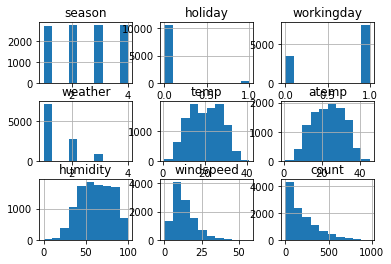

In [28]:
# Create a histogram of all features to show the distribution of each one relative to the data. This is part of the exploritory data analysis

%matplotlib inline
plt.figure(figsize=(16, 9))

train.hist()

Evidently there are some features which are correlated - 
* `holiday` and `workingday` are negatively correlated because a holiday means it is not a workingday and vice versa; these features can be combined into one.
* `weather` seems to be correlated with `count`. This is interesting because the weather column is a ordinal value as of now, This needs to be changed into a categorical feature to make more sense. A weather value of 1 doesn't really mean anything. Also a weather value of 1 isn't really *greater* than a weather value of 4. They refer to different types of weather conditions.
* `temp` and `atemp` are also correlated features, as when actual temperatures are higher, it will also be perveived like higher temperatures. So we can assume that only one of these features can be included in the model, depends upon which one of them has a higher covariance with the target.
* `humidity` is a good one as if the weather is more humid, people are less likely to take bikes. will have to be one-hot encoded
* `windspeed` is also a categorical feature which can be one-hot encoded
* `season` is also a categorical feature which can be one-hot encoded
* `datetime` can be parsed to give out time of the day and further analysis can be done to figure out rush-hour times versus non-rush-hour times.

#### Checking out the `holiday` and `workingday` features

In [29]:
print(f"holiday value counts:\n {train.holiday.value_counts()}")
print(f"workingday value counts:\n {train.workingday.value_counts()}")

holiday value counts:
 0    10575
1      311
Name: holiday, dtype: int64
workingday value counts:
 1    7412
0    3474
Name: workingday, dtype: int64


<AxesSubplot:xlabel='holiday', ylabel='count'>

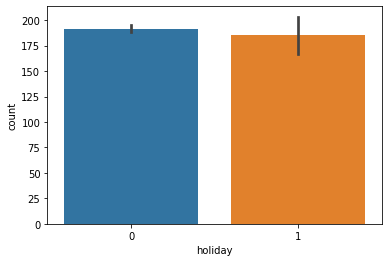

In [30]:
sns.barplot(data=train, x="holiday", y="count")

Now since `holiday` is a categorical feature, we can one-hot encode it, and remove the original feature since it is not ordinal in nature.

In [31]:
# one hot encode the holiday categorical feature
train = train.join(pd.get_dummies(train.holiday, prefix="holiday_"))

Now since `workingday` is a categorical feature, we can one-hot encode it, and remove the original feature since it is not ordinal in nature.

<AxesSubplot:xlabel='workingday', ylabel='count'>

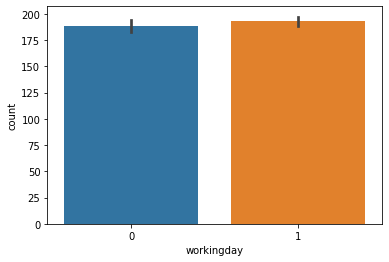

In [32]:
sns.barplot(data=train, x="workingday", y="count")

In [33]:
# one hot encode the workingday feature and add it to the train df
train = train.join(pd.get_dummies(train.workingday, prefix="workingday_")) 

# we can then remove the original workingday feature
train.drop(columns=["workingday", "holiday"], inplace=True)

In [34]:
train.head()

,datetime,season,weather,temp,atemp,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1
0,2011-01-01 00:00:00,1,1,9.84,14.395,81,0.0,16,1,0,1,0
1,2011-01-01 01:00:00,1,1,9.02,13.635,80,0.0,40,1,0,1,0
2,2011-01-01 02:00:00,1,1,9.02,13.635,80,0.0,32,1,0,1,0
3,2011-01-01 03:00:00,1,1,9.84,14.395,75,0.0,13,1,0,1,0
4,2011-01-01 04:00:00,1,1,9.84,14.395,75,0.0,1,1,0,1,0


#### Checking out the `weather` feature

In [35]:
# checking the distribution of values in weather
train.weather.value_counts()

1    7192
2    2834
3     859
4       1
Name: weather, dtype: int64

It is slightly alarming to see that there is only 1 sample for weather = 4

From kaggle it is found that the descriptions for weather are:

* 1: Clear, Few clouds, Partly cloudy, Partly cloudy
* 2: Mist + Cloudy, Mist + Broken clouds, Mist + Few clouds, Mist
* 3: Light Snow, Light Rain + Thunderstorm + Scattered clouds, Light Rain + Scattered clouds
* 4: Heavy Rain + Ice Pallets + Thunderstorm + Mist, Snow + Fog

It is evident that category 3 and 4 can be clustered together into one - Bad Weather. 
Category 1 refers to good clear weather, and Category 2 refers to Cloudy weather.
Moreover Season type 4 has only 1 sample in the training data, so it does not really add much value to our analysis.

So in total we can have 3 Categories:
* Clear
* Cloudy
* Bad Weather

In [36]:
train.loc[train.weather == 2, "weather"]

5        2
13       2
14       2
15       2
16       2
        ..
10835    2
10836    2
10838    2
10839    2
10840    2
Name: weather, Length: 2834, dtype: int64

In [37]:
# one hot encoding the three weather columns and removing the original weather column

train["weather_clear"] = 0
train.loc[train.weather == 1, "weather_clear"] = 1


train["weather_bad"] = 0
train.loc[train.weather == 2, "weather_bad"] = 1


train["weather_cloudy"] = 0
train.loc[(train.weather == 3) | (train.weather == 4), "weather_cloudy"] = 1

In [38]:
train.drop(columns=["weather"], inplace=True)

In [39]:
train.head()

,datetime,season,temp,atemp,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy
0,2011-01-01 00:00:00,1,9.84,14.395,81,0.0,16,1,0,1,0,1,0,0
1,2011-01-01 01:00:00,1,9.02,13.635,80,0.0,40,1,0,1,0,1,0,0
2,2011-01-01 02:00:00,1,9.02,13.635,80,0.0,32,1,0,1,0,1,0,0
3,2011-01-01 03:00:00,1,9.84,14.395,75,0.0,13,1,0,1,0,1,0,0
4,2011-01-01 04:00:00,1,9.84,14.395,75,0.0,1,1,0,1,0,1,0,0


#### Checking the `season` feature

From Kaggle it can be seen that the season feature is categorized as follows:
* 1 = spring 
* 2 = summer
* 3 = fall
* 4 = winter

Which means this is also a categorical feature which needs to be encoded, as the values are not ordinal.

First let us check the distribution of `season` and `count` values.

It is evident that as the season values change, indicating a change in season from 1 to 4, the count values also change, with an increase during summer and fall, and a decrease during winter and spring. So there is a direct relationship between the season and the bike demand counts

<AxesSubplot:xlabel='season', ylabel='count'>

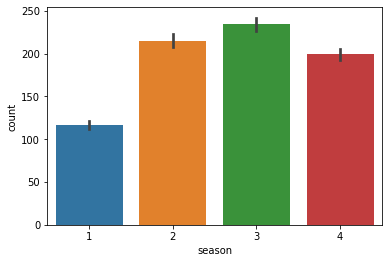

In [40]:
sns.barplot(data = train, x = "season", y = "count")

Let us one-hot encode these features, add them to our dataset and then remove the original feature

In [41]:
train = train.join(pd.get_dummies(train.season, prefix="season_"))
train.drop(columns=["season"], inplace=True)
train.head()

,datetime,temp,atemp,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,season__1,season__2,season__3,season__4
0,2011-01-01 00:00:00,9.84,14.395,81,0.0,16,1,0,1,0,1,0,0,1,0,0,0
1,2011-01-01 01:00:00,9.02,13.635,80,0.0,40,1,0,1,0,1,0,0,1,0,0,0
2,2011-01-01 02:00:00,9.02,13.635,80,0.0,32,1,0,1,0,1,0,0,1,0,0,0
3,2011-01-01 03:00:00,9.84,14.395,75,0.0,13,1,0,1,0,1,0,0,1,0,0,0
4,2011-01-01 04:00:00,9.84,14.395,75,0.0,1,1,0,1,0,1,0,0,1,0,0,0


### Checking out the `atemp` and `temp` columns

First let us check the distribution of `atemp` and `count` values.

<AxesSubplot:xlabel='atemp', ylabel='count'>

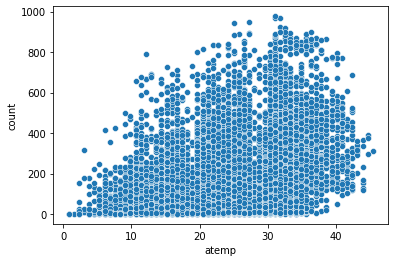

In [42]:
sns.scatterplot(data=train, x = "atemp", y = "count")

There seems to be a roughly positive correlation to temperature and counts. However this isn't clear.

It is evident here that the `atemp` values are discrete in nature even though it is supposed to be continuous. We can thus discretize these values into buckets by creating one-hot vectors.

We can identify the buckets for categorizing the feature using a decision tree model in order to perform feature binning.

 The idea is to find the best set of buckets or bins using a decision tree model that will involve correlation with the target variable.

In [43]:
X_features = train[["atemp"]]
y_label = train["count"].values

In [44]:
params = {
    'max_depth':[2,4,6,8,10,12],
    'min_samples_split':[2,3,5,10]
    }

In [45]:
clf_dt = DecisionTreeRegressor()
clf = GridSearchCV(clf_dt, param_grid=params, scoring="neg_root_mean_squared_error")
clf.fit(X_features, y_label)

GridSearchCV(estimator=DecisionTreeRegressor(),
             param_grid={'max_depth': [2, 4, 6, 8, 10, 12],
                         'min_samples_split': [2, 3, 5, 10]},
             scoring='neg_root_mean_squared_error')

In [46]:
clf.best_params_

{'max_depth': 6, 'min_samples_split': 2}

In [47]:
clf_dt = DecisionTreeRegressor()
clf_dt.max_depth = 6
clf_dt.min_samples_split = 2

clf_dt.fit(X_features, y_label)

DecisionTreeRegressor(max_depth=6)

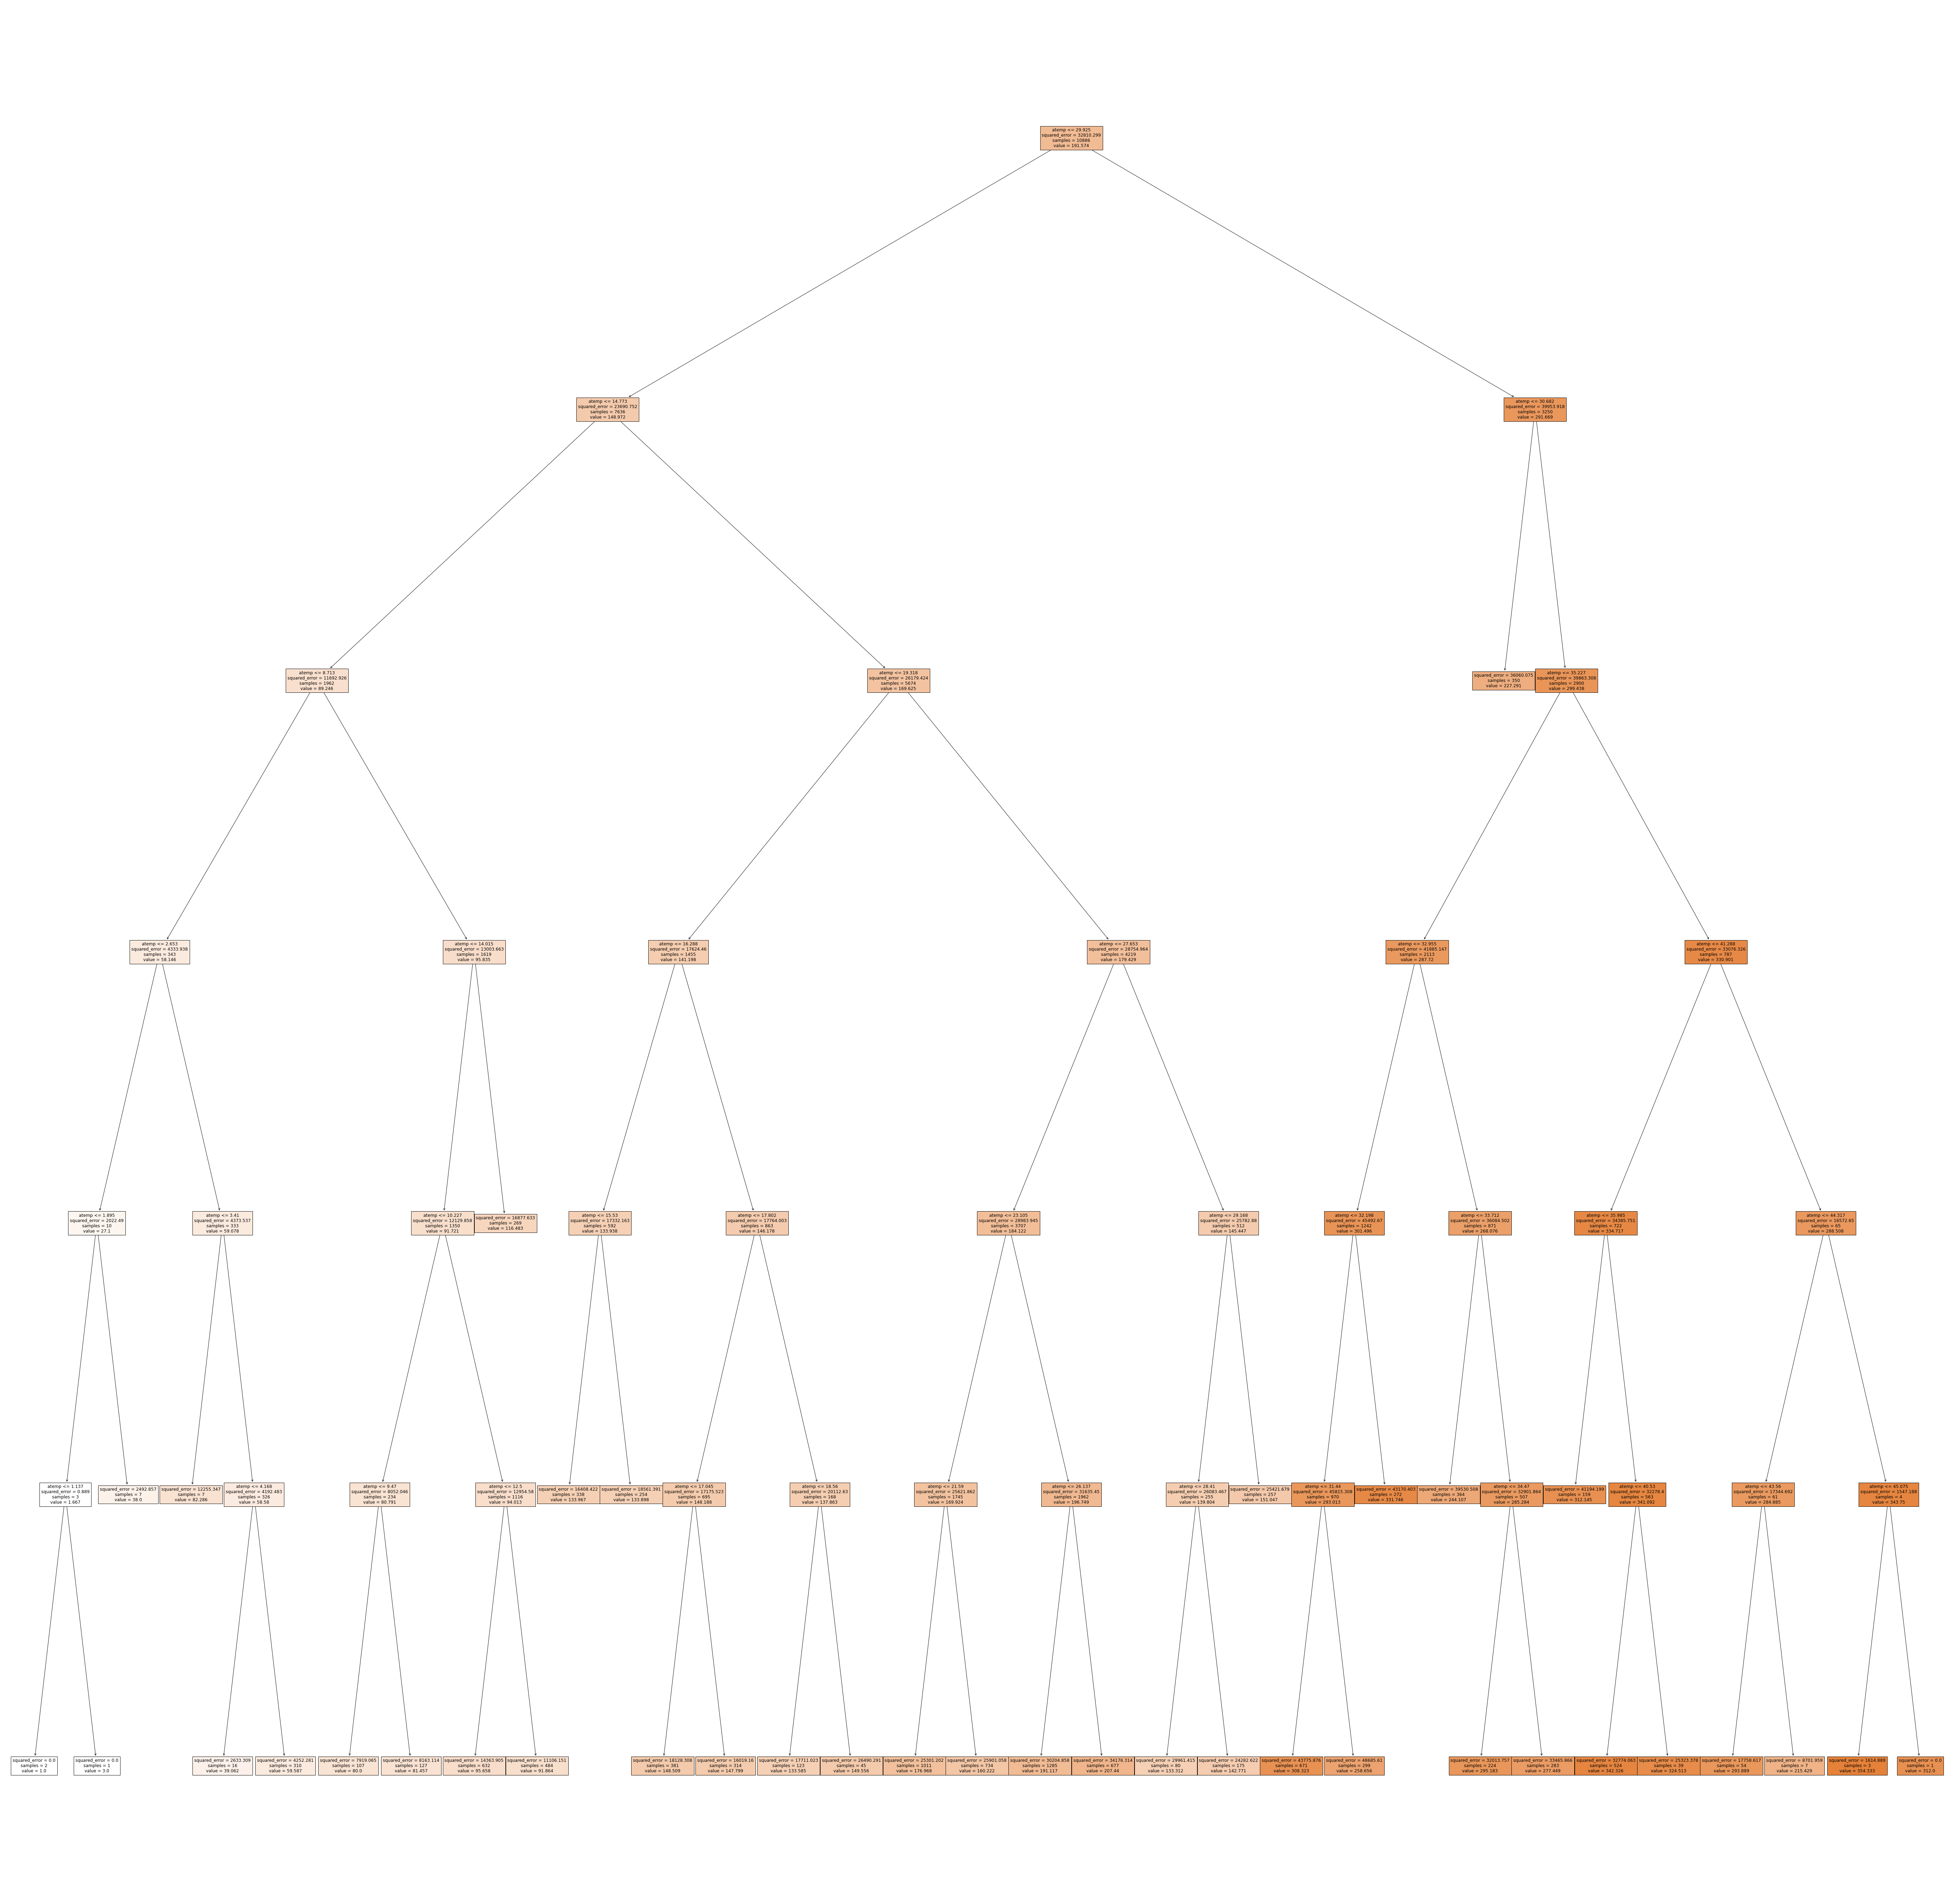

In [48]:
%matplotlib inline
plt.figure(figsize=(100, 100))
plot_tree(clf_dt, filled=True, feature_names=list(X_features.columns))
plt.show()

Based on the above, we can see that the bins are structured as follows, since we have 6 nodes in the tree, we can bin the temperatures into 6 categories, which exhibit the highest entropy based splits:
* `1`: values from 0-7.5
* `2`: values from 7.5-15
* `3`: values from 15-22.5
* `4`: values from 22.5-30   
* `5`: values from 30-37.5
* `6`: values from 37.5-46

In [49]:
train["atemp_1"] = 0
train.loc[train.atemp <=7.5 , "atemp_1"] = 1

train["atemp_2"] = 0
train.loc[(train.atemp > 7.5) & (train.atemp <= 15), "atemp_2"] = 1

train["atemp_3"] = 0
train.loc[(train.atemp > 15) & (train.atemp <= 22.5), "atemp_3"] = 1

train["atemp_4"] = 0
train.loc[(train.atemp > 22.5) & (train.atemp <= 30), "atemp_4"] = 1

train["atemp_5"] = 0
train.loc[(train.atemp > 30) & (train.atemp <= 37.5), "atemp_5"] = 1

train["atemp_6"] = 0
train.loc[(train.atemp > 37.5) & (train.atemp <= 46), "atemp_6"] = 1

We can now discard the original `atemp` and `temp` columns, however let us check the correlation between the two.

Correlation coefficient between atemp and temp is: 0.9849481104817066


<AxesSubplot:xlabel='atemp', ylabel='temp'>

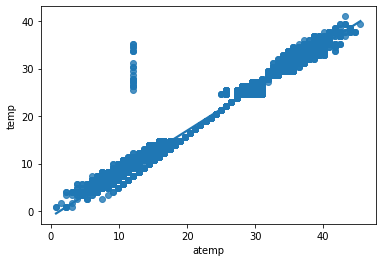

In [50]:
print(f"Correlation coefficient between atemp and temp is: {train.atemp.corr(train.temp)}")
sns.regplot(x=train.atemp, y=train.temp)

As is evident, these 2 are highly correlated. But the feature that we need to keep is the one that has a higher covariance with the target.

<AxesSubplot:>

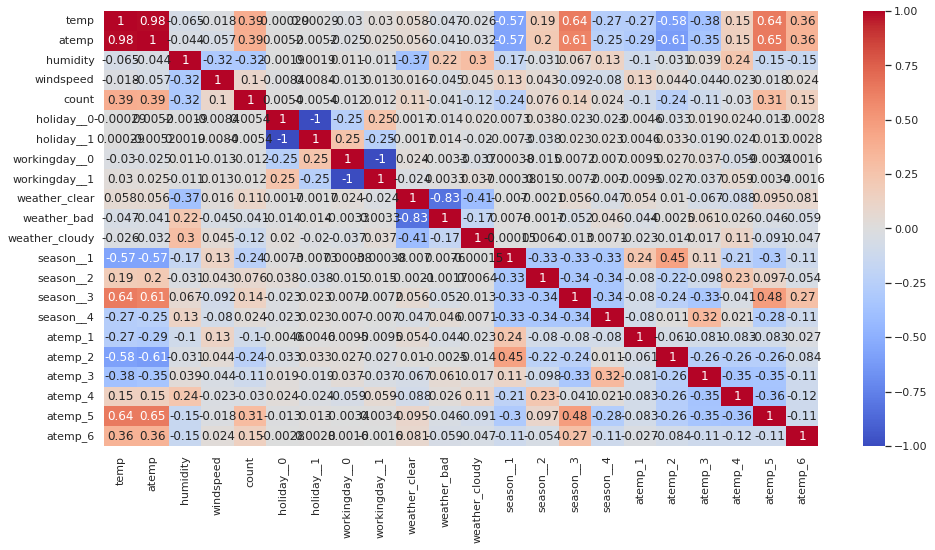

In [51]:
sns.set(rc = {'figure.figsize':(16,8)})
sns.heatmap(train.corr(), annot = True, fmt='.2g',cmap= 'coolwarm')


Since `atemp` and `temp` are both similarly correlated with the target, we can remove them both and have the one-hot encoded features.

In [52]:
train.drop(columns=["atemp", "temp"], inplace=True)
train.head()

,datetime,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,...,season__1,season__2,season__3,season__4,atemp_1,atemp_2,atemp_3,atemp_4,atemp_5,atemp_6
0,2011-01-01 00:00:00,81,0.0,16,1,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
1,2011-01-01 01:00:00,80,0.0,40,1,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
2,2011-01-01 02:00:00,80,0.0,32,1,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
3,2011-01-01 03:00:00,75,0.0,13,1,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0
4,2011-01-01 04:00:00,75,0.0,1,1,0,1,0,1,0,...,1,0,0,0,0,1,0,0,0,0


### Checking out the `datetime` feature

The datetime feature contains the datetime stamp in the format: `YYYY-MM-DD HH:MM:SS`

There are a few features than can be generated from this field, which we will corroborate with the following hypotheses:

* Does count have any relationship with the year? Is there an annual trend in count numbers with the year?
* Does count have any relationship with the month? Which is essentially the seasonal/monthly trend in bike demand
* Does the day of the week matter to the bike trend? It can be assumed that weekdays will see more demand than weekends, which can also be obtained from the holiday/workingday feature. So this may not add much value. We can check the correlation of the 2 variables to make a decision.
* Does count display an hourly trend? It can be assumed that bike demand increases during rush hours.

In [53]:
train.datetime

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [54]:
# train.datetime.values[0].split(" ")[1].split(":")[0]
train.datetime.values[0].split(" ")[0].split("-")[2]

'01'

In [55]:
# define an auxillary function to extract datetime, given a string containing the YYYY-MM-DD HH:MM:SS format
def extract_hour(timestamp):
    hour = timestamp.split(" ")[1].split(":")[0]
    hour = int(hour) # convert to integer type for easy calculation later on
    return hour

def extract_year(timestamp):
    year = timestamp.split(" ")[0].split("-")[0]
    year = int(year) # convert to integer type for easy calculation later on
    return year

def extract_month(timestamp):
    month = timestamp.split(" ")[0].split("-")[1]
    month = int(month) # convert to integer type for easy calculation later on
    return month

def extract_day(timestamp):
    day = timestamp.split(" ")[0].split("-")[2]
    day = int(day) # convert to integer type for easy calculation later on
    return day

In [56]:
# add the hour to the dataframe as a new feature

train["time_of_day"] = train.datetime.apply(extract_hour).values

# add the year to the dataframe as a new feature

train["year"] = train.datetime.apply(extract_year).values

# add the month to the dataframe as a new feature

train["month"] = train.datetime.apply(extract_month).values

# add the day to the dataframe as a new feature

train["day"] = train.datetime.apply(extract_day).values

train.head()

,datetime,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,...,atemp_1,atemp_2,atemp_3,atemp_4,atemp_5,atemp_6,time_of_day,year,month,day
0,2011-01-01 00:00:00,81,0.0,16,1,0,1,0,1,0,...,0,1,0,0,0,0,0,2011,1,1
1,2011-01-01 01:00:00,80,0.0,40,1,0,1,0,1,0,...,0,1,0,0,0,0,1,2011,1,1
2,2011-01-01 02:00:00,80,0.0,32,1,0,1,0,1,0,...,0,1,0,0,0,0,2,2011,1,1
3,2011-01-01 03:00:00,75,0.0,13,1,0,1,0,1,0,...,0,1,0,0,0,0,3,2011,1,1
4,2011-01-01 04:00:00,75,0.0,1,1,0,1,0,1,0,...,0,1,0,0,0,0,4,2011,1,1


First we start with the `year` feature we just generated. Let us check for annual trends in bike demand.

<AxesSubplot:xlabel='year', ylabel='count'>

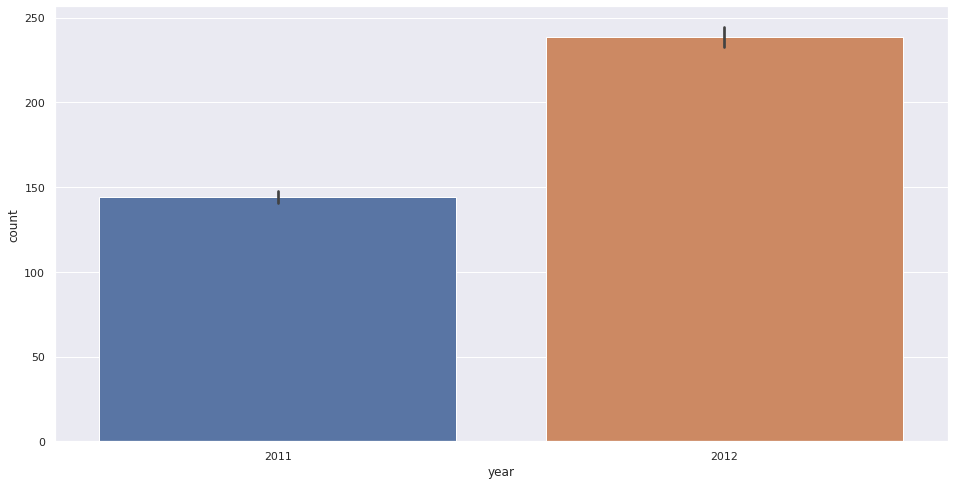

In [57]:
sns.barplot(data=train, x="year", y="count")

It is evident that there was a significant rise in bike demand in 2012. This may be due to external factors which we do not have access to, however since we have datapoints from 2011 in our test data, it makes sense that the year will play a part in predicting bike demand.

We need to convert the year into a categorical feature as well.

Currently we have integer values in `year`, which needs to be mapped into categorical features. We can one-hot encode these into new features, and drop the original year column.

In [58]:
train = train.join(pd.get_dummies(train.year, prefix="year_"))
train.drop(columns=["year"], inplace=True)
train.head()

,datetime,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,...,atemp_2,atemp_3,atemp_4,atemp_5,atemp_6,time_of_day,month,day,year__2011,year__2012
0,2011-01-01 00:00:00,81,0.0,16,1,0,1,0,1,0,...,1,0,0,0,0,0,1,1,1,0
1,2011-01-01 01:00:00,80,0.0,40,1,0,1,0,1,0,...,1,0,0,0,0,1,1,1,1,0
2,2011-01-01 02:00:00,80,0.0,32,1,0,1,0,1,0,...,1,0,0,0,0,2,1,1,1,0
3,2011-01-01 03:00:00,75,0.0,13,1,0,1,0,1,0,...,1,0,0,0,0,3,1,1,1,0
4,2011-01-01 04:00:00,75,0.0,1,1,0,1,0,1,0,...,1,0,0,0,0,4,1,1,1,0


Now let us look at the seasonal/monthly trends of `count`

<AxesSubplot:xlabel='month', ylabel='count'>

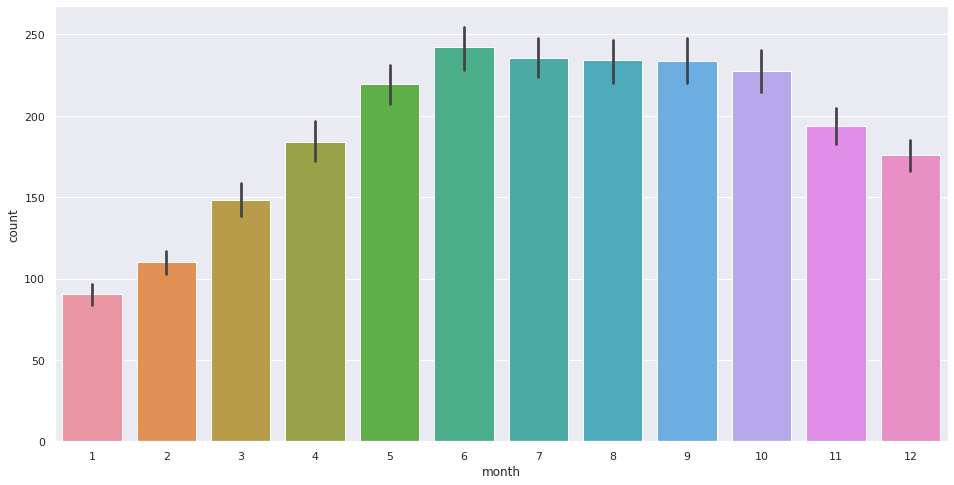

In [59]:
sns.barplot(data=train, x="month", y="count")

As is evident, there is an obvious monthly/seasonal trend in bike demand as well, with more bikes being rented out from June - Sept.

We can model this variation by having categorical features denote the month as well.

In [60]:
train = train.join(pd.get_dummies(train.month, prefix="month_"))
train.drop(columns=["month"], inplace=True)
train.head()

,datetime,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,...,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
0,2011-01-01 00:00:00,81,0.0,16,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
1,2011-01-01 01:00:00,80,0.0,40,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
2,2011-01-01 02:00:00,80,0.0,32,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
3,2011-01-01 03:00:00,75,0.0,13,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0
4,2011-01-01 04:00:00,75,0.0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,0


Now let us look at the daily trends of `count`

<AxesSubplot:xlabel='day', ylabel='count'>

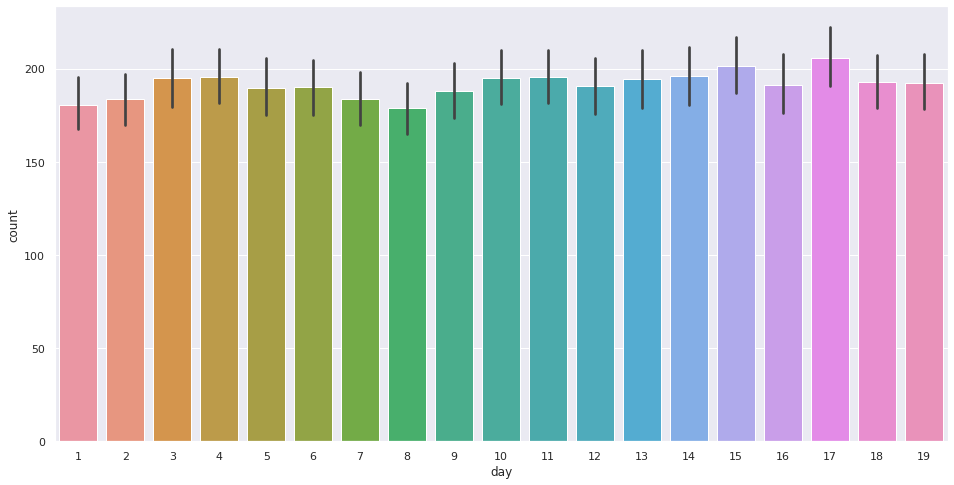

In [61]:
sns.barplot(data=train, x="day", y="count")

This isn't really showing us much, as there aren't any obvious patterns or trends here. A better comparision would be to check whether there are trends between count and a weekday/weekend, and since the 1st of every month (or 2nd, 3rd etc) aren't always a weekday (or weekend) we need to figure out a way to extract that information first.

In order to do that we can use the $datetime$ module

In [62]:
train.datetime

0        2011-01-01 00:00:00
1        2011-01-01 01:00:00
2        2011-01-01 02:00:00
3        2011-01-01 03:00:00
4        2011-01-01 04:00:00
                ...         
10881    2012-12-19 19:00:00
10882    2012-12-19 20:00:00
10883    2012-12-19 21:00:00
10884    2012-12-19 22:00:00
10885    2012-12-19 23:00:00
Name: datetime, Length: 10886, dtype: object

In [63]:
# convert the datetime values from string type to datetime type
train.datetime = train.datetime.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

In [64]:
# find out the weekdays
# add as a new feature
train["day_of_week"] = train.datetime.apply(lambda x: x.weekday())
train.head()

,datetime,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,day_of_week
0,2011-01-01 00:00:00,81,0.0,16,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,5
1,2011-01-01 01:00:00,80,0.0,40,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,5
2,2011-01-01 02:00:00,80,0.0,32,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,5
3,2011-01-01 03:00:00,75,0.0,13,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,5
4,2011-01-01 04:00:00,75,0.0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,0,5


Let us check the trend based on weekday/weekend with count

<AxesSubplot:xlabel='day_of_week', ylabel='count'>

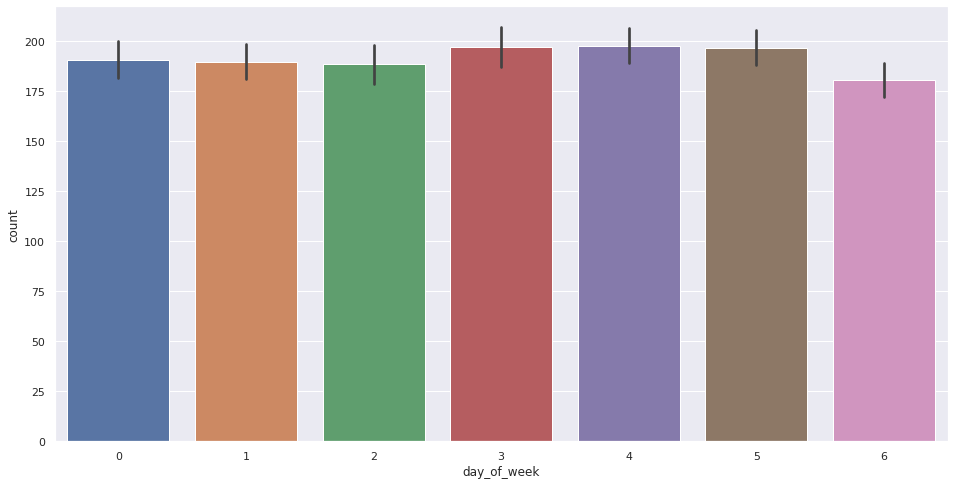

In [65]:
sns.barplot(data=train, x="day_of_week", y="count")

This seems to show more of a consistent trend, with:
* medium demand on mon, tue, wed, 
* max demand on thu, fri and sat,
* min demand on sun

This seems to be consistent with the idea that more people want bikes on weekdays rather than weekends.

We can thus bin these into 3 buckets:
* Mon-Wed
* Thu-Sat
* Sun

In [66]:
# Mon-Wed
train["early_week"] = 0
train.loc[train.day_of_week.between(0,2), "early_week"] = 1

# Thu-Sat
train["pre_weekend"] = 0
train.loc[train.day_of_week.between(3,5), "pre_weekend"] = 1

# Sunday
train["sunday"] = 0
train.loc[train.day_of_week == 6, "sunday"] = 1

train.drop(columns=["day_of_week", "day"], inplace=True)
train.head()

,datetime,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,...,month__6,month__7,month__8,month__9,month__10,month__11,month__12,early_week,pre_weekend,sunday
0,2011-01-01 00:00:00,81,0.0,16,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
1,2011-01-01 01:00:00,80,0.0,40,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
2,2011-01-01 02:00:00,80,0.0,32,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
3,2011-01-01 03:00:00,75,0.0,13,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0
4,2011-01-01 04:00:00,75,0.0,1,1,0,1,0,1,0,...,0,0,0,0,0,0,0,0,1,0


In [67]:
train.columns

Index(['datetime', 'humidity', 'windspeed', 'count', 'holiday__0',
       'holiday__1', 'workingday__0', 'workingday__1', 'weather_clear',
       'weather_bad', 'weather_cloudy', 'season__1', 'season__2', 'season__3',
       'season__4', 'atemp_1', 'atemp_2', 'atemp_3', 'atemp_4', 'atemp_5',
       'atemp_6', 'time_of_day', 'year__2011', 'year__2012', 'month__1',
       'month__2', 'month__3', 'month__4', 'month__5', 'month__6', 'month__7',
       'month__8', 'month__9', 'month__10', 'month__11', 'month__12',
       'early_week', 'pre_weekend', 'sunday'],
      dtype='object')

Now based on the `time_of_day` feature we can engineer other new features, which will be categorical so we will have to one-hot encode them as well.

We start by figuring out the logic for the bins.

We find out the bins for the time of day similar to how we did for the atemp feature. We use a decision tree regressor to figure out the nodes of best split.

In [68]:
X_features = train[["time_of_day"]]
y_label = train["count"].values

params = {
    'max_depth':[2,4,6,8,10,12],
    'min_samples_split':[2,3,5,10]
    }

clf_dt = DecisionTreeRegressor()
clf = GridSearchCV(clf_dt, param_grid=params, scoring="neg_root_mean_squared_error")
clf.fit(X_features, y_label)

clf.best_params_

{'max_depth': 8, 'min_samples_split': 2}

In [69]:
clf_dt = DecisionTreeRegressor()
clf_dt.max_depth = 5
clf_dt.min_samples_split = 2

clf_dt.fit(X_features, y_label)

DecisionTreeRegressor(max_depth=5)

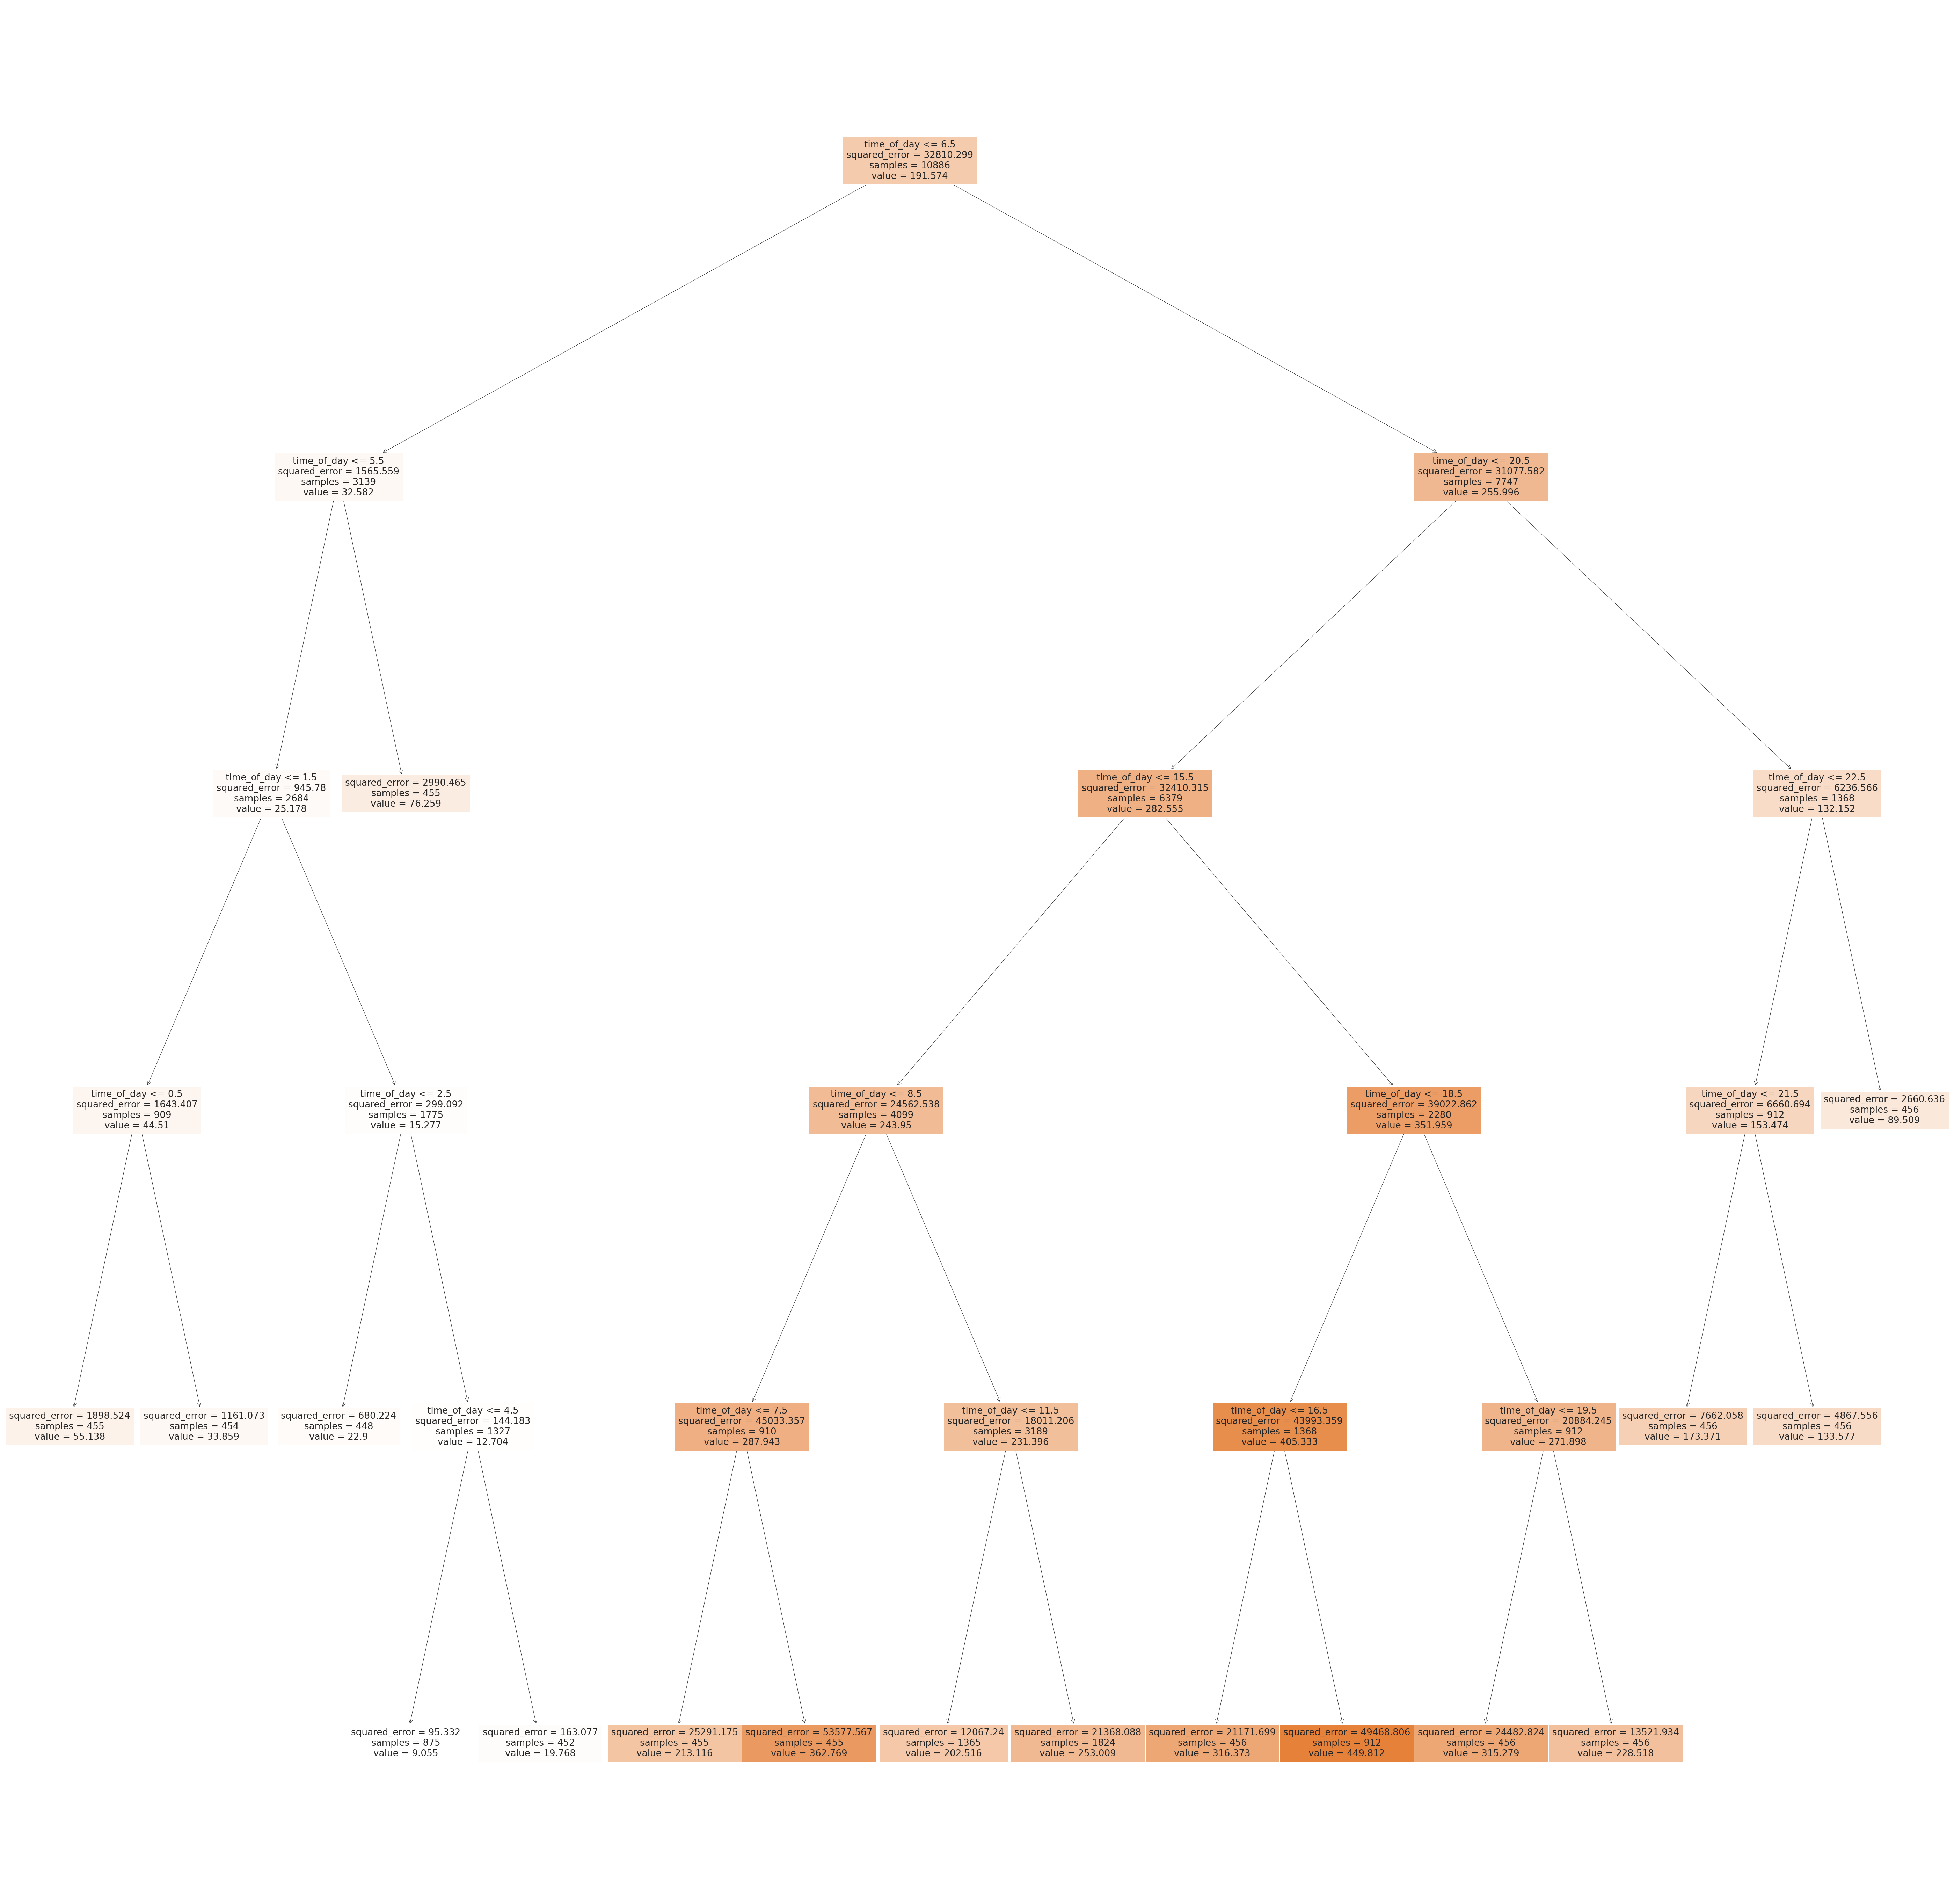

In [70]:
%matplotlib inline
plt.figure(figsize=(100, 100))
plot_tree(clf_dt, filled=True, feature_names=list(X_features.columns))
plt.show()

Let us corroborate this node split with the trends seen hourly as well

<AxesSubplot:xlabel='time_of_day', ylabel='count'>

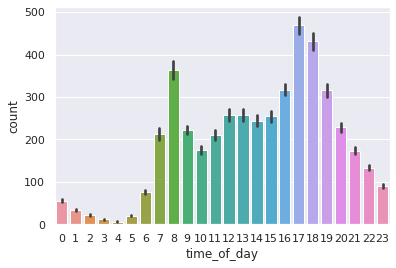

In [71]:
sns.barplot(data = train, x="time_of_day", y="count")

According to both the plots we can safely assume that the bins for the hourly trends look like:
* 0 - 4.5
* 4.5 - 6.5
* 6.5 - 8.5
* 8.5 - 15.5
* 15.5 - 18.5
* 18.5 - 20.5
* 20.5 - 22.5
* 22.5 - 24

As is evident the rush hour times see the most spike in demand. So we can use this as a feature.

In [72]:
# let us create the new columns

train["time_0"] = 0
train.loc[(train.time_of_day > 0) & (train.time_of_day <= 4.5), "time_0"] = 1

train["time_1"] = 0
train.loc[(train.time_of_day > 4.5) & (train.time_of_day <= 6.5), "time_1"] = 1

train["time_2"] = 0
train.loc[(train.time_of_day > 6.5) & (train.time_of_day <= 8.5), "time_2"] = 1

train["time_3"] = 0
train.loc[(train.time_of_day > 8.5) & (train.time_of_day <= 15.5), "time_3"] = 1

train["time_4"] = 0
train.loc[(train.time_of_day > 15.5) & (train.time_of_day <= 18.5), "time_4"] = 1

train["time_5"] = 0
train.loc[(train.time_of_day > 18.5) & (train.time_of_day <= 20.5), "time_5"] = 1

train["time_6"] = 0
train.loc[(train.time_of_day > 20.5) & (train.time_of_day <= 22.5), "time_6"] = 1

train["time_7"] = 0
train.loc[(train.time_of_day > 22.5) & (train.time_of_day <= 24), "time_7"] = 1

# and we can remove the original time_of_day feature
train.drop(columns=["time_of_day"], inplace = True)

train.head()

,datetime,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,...,pre_weekend,sunday,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7
0,2011-01-01 00:00:00,81,0.0,16,1,0,1,0,1,0,...,1,0,0,0,0,0,0,0,0,0
1,2011-01-01 01:00:00,80,0.0,40,1,0,1,0,1,0,...,1,0,1,0,0,0,0,0,0,0
2,2011-01-01 02:00:00,80,0.0,32,1,0,1,0,1,0,...,1,0,1,0,0,0,0,0,0,0
3,2011-01-01 03:00:00,75,0.0,13,1,0,1,0,1,0,...,1,0,1,0,0,0,0,0,0,0
4,2011-01-01 04:00:00,75,0.0,1,1,0,1,0,1,0,...,1,0,1,0,0,0,0,0,0,0


### Checking out the `humidity` and `windspeed` features.

From what it looks like, it might be better to leave humidity and windspeed as continuous variables rather than convert them into categorical. 
However since they are on a different scale from the other one-hot encoded features, it is imperative that they be standard-normalized so that they don't get extra weightage while the models train.

In [73]:
# before we can perform standardization we need to remove the datetime column as well since it is a string
train.drop(columns=["datetime"], inplace=True)
train.head()

,humidity,windspeed,count,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,...,pre_weekend,sunday,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7
0,81,0.0,16,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,80,0.0,40,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
2,80,0.0,32,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
3,75,0.0,13,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
4,75,0.0,1,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0


Let us look at the distributions of `humidity` and `windpeed`

<AxesSubplot:xlabel='humidity', ylabel='Count'>

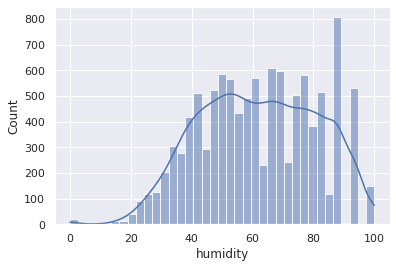

In [74]:
sns.histplot(data=train, x="humidity", kde=True)

<AxesSubplot:xlabel='windspeed', ylabel='Count'>

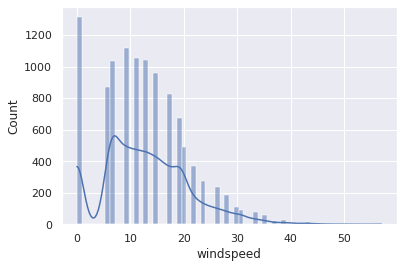

In [75]:
sns.histplot(data=train, x="windspeed", kde=True)

Looks like humidity is almost normally distributed, so we can just standardize those values using min-max scaling. 

However windspeed seems quite skewed. We can normalize windspeed, but there are quite a few 0s which seem like they are outliers. We can treat them as missing values/error values, and based on other features which affect windspeed, estimate the value of windspeed for those values. 

We can then check the distribution to see if that has improved the distribution to be more normal.

We can make a preprocessing pipeline for the other features so that we can do a one-step preprocess of the train and test data, which can then be used to model both the `count` predictor as well as for the `windspeed` predictor

## Make category types for these so models know they are not just numbers
* AutoGluon originally sees these as ints, but in reality they are int representations of a category.
* Setting the dtype to category will classify these as categories in AutoGluon.

In [76]:
for col in train.columns:
    if col not in ['humidity', 'windspeed', 'count']:
        train[col] = train[col].astype("category")

array([[<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'windspeed'}>],
       [<AxesSubplot:title={'center':'count'}>, <AxesSubplot:>]],
      dtype=object)

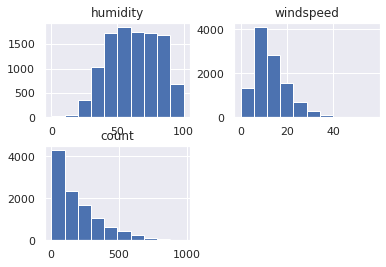

In [77]:
# View histogram of all features again now with the hour feature
train.hist()

# Define a pre-processing pipeline function
* depending upon the type of dataset:
    * the pre-processed train dataset will contain the `count` label parameter
    * the pre-processed test dataset will *not* contain the `count` label parameter
* call the function to do a one step pre-processing of the entire dataset

In [78]:
# define an auxillary function to extract datetime, given a string containing the YYYY-MM-DD HH:MM:SS format
def extract_hour(timestamp):
    hour = timestamp.split(" ")[1].split(":")[0]
    hour = int(hour) # convert to integer type for easy calculation later on
    return hour

def extract_year(timestamp):
    year = timestamp.split(" ")[0].split("-")[0]
    year = int(year) # convert to integer type for easy calculation later on
    return year

def extract_month(timestamp):
    month = timestamp.split(" ")[0].split("-")[1]
    month = int(month) # convert to integer type for easy calculation later on
    return month

def extract_day(timestamp):
    day = timestamp.split(" ")[0].split("-")[2]
    day = int(day) # convert to integer type for easy calculation later on
    return day

In [79]:
def preprocess_data(df):
    #  one hot encode the holiday feature and add it to the train df
    df = df.join(pd.get_dummies(df.holiday, prefix="holiday_")) 
    df.drop(columns=["holiday"], inplace=True)
    
    # one hot encode the workingday feature and add it to the train df
    df = df.join(pd.get_dummies(df.workingday, prefix="workingday_")) 
    # we can then remove the original workingday feature
    df.drop(columns=["workingday"], inplace=True)

    # one hot encoding the three weather columns and removing the original weather column
    df["weather_clear"] = 0
    df.loc[df.weather == 1, "weather_clear"] = 1

    df["weather_bad"] = 0
    df.loc[df.weather == 2, "weather_bad"] = 1
    
    df["weather_cloudy"] = 0
    df.loc[(df.weather == 3) | (df.weather == 4), "weather_cloudy"] = 1

    df.drop(columns=["weather"], inplace=True)
    
    # one hot encoding the season column
    df = df.join(pd.get_dummies(df.season, prefix="season_"))
    df.drop(columns=["season"], inplace=True)

    # one hot encoding the temp bins
    df["atemp_1"] = 0
    df.loc[df.atemp <=7.5 , "atemp_1"] = 1

    df["atemp_2"] = 0
    df.loc[(df.atemp > 7.5) & (df.atemp <= 15), "atemp_2"] = 1

    df["atemp_3"] = 0
    df.loc[(df.atemp > 15) & (df.atemp <= 22.5), "atemp_3"] = 1

    df["atemp_4"] = 0
    df.loc[(df.atemp > 22.5) & (df.atemp <= 30), "atemp_4"] = 1

    df["atemp_5"] = 0
    df.loc[(df.atemp > 30) & (df.atemp <= 37.5), "atemp_5"] = 1

    df["atemp_6"] = 0
    df.loc[(df.atemp > 37.5) & (df.atemp <= 46), "atemp_6"] = 1

    df.drop(columns=["atemp", "temp"], inplace=True)

    # add the hour to the dataframe as a new feature
    df["time_of_day"] = df.datetime.apply(extract_hour).values

    # add the year to the dataframe as a new feature
    df["year"] = df.datetime.apply(extract_year).values

    # add the month to the dataframe as a new feature
    df["month"] = df.datetime.apply(extract_month).values

    # add the day to the dataframe as a new feature
    df["day"] = df.datetime.apply(extract_day).values

    # one hot encode the year feature
    df = df.join(pd.get_dummies(df.year, prefix="year_"))
    df.drop(columns=["year"], inplace=True)

    # one hot encode the month feature
    df = df.join(pd.get_dummies(df.month, prefix="month_"))
    df.drop(columns=["month"], inplace=True)

    # convert the datetime values from string type to datetime type
    df.datetime = df.datetime.apply(lambda x: datetime.strptime(x, "%Y-%m-%d %H:%M:%S"))

    # find out the weekdays
    # add as a new feature
    df["day_of_week"] = df.datetime.apply(lambda x: x.weekday())

    # Mon-Wed
    df["early_week"] = 0
    df.loc[df.day_of_week.between(0,2), "early_week"] = 1

    # Thu-Sat
    df["pre_weekend"] = 0
    df.loc[df.day_of_week.between(3,5), "pre_weekend"] = 1

    # Sunday
    df["sunday"] = 0
    df.loc[df.day_of_week == 6, "sunday"] = 1

    df.drop(columns=["day_of_week", "day"], inplace=True)

    # let us create the new columns
    # ont hot encode the time of day feature
    df["time_0"] = 0
    df.loc[(df.time_of_day > 0) & (df.time_of_day <= 4.5), "time_0"] = 1

    df["time_1"] = 0
    df.loc[(df.time_of_day > 4.5) & (df.time_of_day <= 6.5), "time_1"] = 1

    df["time_2"] = 0
    df.loc[(df.time_of_day > 6.5) & (df.time_of_day <= 8.5), "time_2"] = 1

    df["time_3"] = 0
    df.loc[(df.time_of_day > 8.5) & (df.time_of_day <= 15.5), "time_3"] = 1

    df["time_4"] = 0
    df.loc[(df.time_of_day > 15.5) & (df.time_of_day <= 18.5), "time_4"] = 1

    df["time_5"] = 0
    df.loc[(df.time_of_day > 18.5) & (df.time_of_day <= 20.5), "time_5"] = 1

    df["time_6"] = 0
    df.loc[(df.time_of_day > 20.5) & (df.time_of_day <= 22.5), "time_6"] = 1

    df["time_7"] = 0
    df.loc[(df.time_of_day > 22.5) & (df.time_of_day <= 24), "time_7"] = 1

    # and we can remove the original time_of_day feature
    df.drop(columns=["time_of_day"], inplace = True)

    # before we can perform standardization we need to remove the datetime column as well since it is a string
    df.drop(columns=["datetime"], inplace=True)
    
    return df

In [80]:
# read in the required raw datasets
train_df = pd.read_csv("./train.csv")
test_df = pd.read_csv("./test.csv")

# dropping columns from training dataset which are not present in test dataset
train_df.drop(columns = ["casual", "registered"], inplace=True)

In [81]:
train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,40
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,32
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,13
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,1


In [82]:
test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,56,26.0027
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,56,0.0000
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,56,0.0000
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,56,11.0014
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,56,11.0014


In [83]:
# train_ws_max = train_df.windspeed.max()
train_hum_max = train_df.humidity.max()

In [84]:
# train_ws_min = train_df.windspeed.min()
train_hum_min = train_df.humidity.min()

In [85]:
# we cannot perform scaling differently on the test set, it has to be min-max scaled based on the train samples
# standardize the humidity column using min-max scaling
normalized_df=(train_df[["humidity"]]-train_hum_min)/(train_hum_max-train_hum_min)
train_df.drop(columns=["humidity"], inplace=True)
train_df = train_df.join(normalized_df)

train_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,windspeed,count,humidity
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,0.0,16,0.81
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,0.0,40,0.80
2,2011-01-01 02:00:00,1,0,0,1,9.02,13.635,0.0,32,0.80
3,2011-01-01 03:00:00,1,0,0,1,9.84,14.395,0.0,13,0.75
4,2011-01-01 04:00:00,1,0,0,1,9.84,14.395,0.0,1,0.75


In [86]:
# now use the min and max values from the train df to scale the test variables
normalized_df=(test_df[["humidity"]]-train_hum_min)/(train_hum_max-train_hum_min)
test_df.drop(columns=["humidity"], inplace=True)
test_df = test_df.join(normalized_df)

test_df.head()

,datetime,season,holiday,workingday,weather,temp,atemp,windspeed,humidity
0,2011-01-20 00:00:00,1,0,1,1,10.66,11.365,26.0027,0.56
1,2011-01-20 01:00:00,1,0,1,1,10.66,13.635,0.0000,0.56
2,2011-01-20 02:00:00,1,0,1,1,10.66,13.635,0.0000,0.56
3,2011-01-20 03:00:00,1,0,1,1,10.66,12.880,11.0014,0.56
4,2011-01-20 04:00:00,1,0,1,1,10.66,12.880,11.0014,0.56


In [87]:
preprocessed_train_data = preprocess_data(train_df)
preprocessed_test_data = preprocess_data(test_df)

In [88]:
preprocessed_train_data.head()

,windspeed,count,humidity,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,...,pre_weekend,sunday,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7
0,0.0,16,0.81,1,0,1,0,1,0,0,...,1,0,0,0,0,0,0,0,0,0
1,0.0,40,0.80,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
2,0.0,32,0.80,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
3,0.0,13,0.75,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0
4,0.0,1,0.75,1,0,1,0,1,0,0,...,1,0,1,0,0,0,0,0,0,0


In [89]:
# cast to categorical datatype
for col in preprocessed_train_data.columns:
    if col not in ['humidity', 'windspeed', 'count']:
        preprocessed_train_data[col] = preprocessed_train_data[col].astype("category")

In [90]:
preprocessed_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 45 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   windspeed       10886 non-null  float64 
 1   count           10886 non-null  int64   
 2   humidity        10886 non-null  float64 
 3   holiday__0      10886 non-null  category
 4   holiday__1      10886 non-null  category
 5   workingday__0   10886 non-null  category
 6   workingday__1   10886 non-null  category
 7   weather_clear   10886 non-null  category
 8   weather_bad     10886 non-null  category
 9   weather_cloudy  10886 non-null  category
 10  season__1       10886 non-null  category
 11  season__2       10886 non-null  category
 12  season__3       10886 non-null  category
 13  season__4       10886 non-null  category
 14  atemp_1         10886 non-null  category
 15  atemp_2         10886 non-null  category
 16  atemp_3         10886 non-null  category
 17  atemp_4     

Same for test data

In [91]:
preprocessed_test_data.head()

,windspeed,humidity,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,season__1,...,pre_weekend,sunday,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7
0,26.0027,0.56,1,0,0,1,1,0,0,1,...,1,0,0,0,0,0,0,0,0,0
1,0.0000,0.56,1,0,0,1,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
2,0.0000,0.56,1,0,0,1,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
3,11.0014,0.56,1,0,0,1,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0
4,11.0014,0.56,1,0,0,1,1,0,0,1,...,1,0,1,0,0,0,0,0,0,0


In [92]:
# cast to categorical datatype
for col in preprocessed_test_data.columns:
    if col not in ['humidity', 'windspeed']:
        preprocessed_test_data[col] = preprocessed_test_data[col].astype("category")

In [93]:
preprocessed_test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6493 entries, 0 to 6492
Data columns (total 44 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   windspeed       6493 non-null   float64 
 1   humidity        6493 non-null   float64 
 2   holiday__0      6493 non-null   category
 3   holiday__1      6493 non-null   category
 4   workingday__0   6493 non-null   category
 5   workingday__1   6493 non-null   category
 6   weather_clear   6493 non-null   category
 7   weather_bad     6493 non-null   category
 8   weather_cloudy  6493 non-null   category
 9   season__1       6493 non-null   category
 10  season__2       6493 non-null   category
 11  season__3       6493 non-null   category
 12  season__4       6493 non-null   category
 13  atemp_1         6493 non-null   category
 14  atemp_2         6493 non-null   category
 15  atemp_3         6493 non-null   category
 16  atemp_4         6493 non-null   category
 17  atemp_5       

# Run an estimation model for the `windspeed` feature

We first combine the train and test data for this

In [128]:
combined_df = preprocessed_train_data.append(preprocessed_test_data, ignore_index=True)
combined_df.head()
combined_df.drop(columns=['count'], inplace=True)

In [129]:
combined_df.describe()

,windspeed,humidity
count,17379.000000,17379.000000
mean,12.736540,0.627229
std,8.196795,0.192930
min,0.000000,0.000000
25%,7.001500,0.480000
50%,12.998000,0.630000
75%,16.997900,0.780000
max,56.996900,1.000000


In [130]:
combined_df.columns

Index(['windspeed', 'humidity', 'holiday__0', 'holiday__1', 'workingday__0',
       'workingday__1', 'weather_clear', 'weather_bad', 'weather_cloudy',
       'season__1', 'season__2', 'season__3', 'season__4', 'atemp_1',
       'atemp_2', 'atemp_3', 'atemp_4', 'atemp_5', 'atemp_6', 'year__2011',
       'year__2012', 'month__1', 'month__2', 'month__3', 'month__4',
       'month__5', 'month__6', 'month__7', 'month__8', 'month__9', 'month__10',
       'month__11', 'month__12', 'early_week', 'pre_weekend', 'sunday',
       'time_0', 'time_1', 'time_2', 'time_3', 'time_4', 'time_5', 'time_6',
       'time_7'],
      dtype='object')

Necessary features for estimating `windspeed` are:
* season
* humidity
* weather
* atemp
* month

In [131]:
from scipy.stats import boxcox
from sklearn.metrics import mean_squared_error, r2_score
import xgboost as xgb

In [132]:
feature_names = [x for x in list(combined_df.columns) if x not in ["holiday__0", "holiday__1", 
                                                                   "workingday__0", "workingday__1", 
                                                                   "year__2011", "year__2012", 
                                                                   "pre_weekend", "sunday", "early_week",
                                                                   "time_0",'time_1','time_2','time_3','time_4','time_5','time_6','time_7'
                                                                  ]]

In [133]:
combined_df = combined_df.loc[:, feature_names]

In [134]:
combined_df

,windspeed,humidity,weather_clear,weather_bad,weather_cloudy,season__1,season__2,season__3,season__4,atemp_1,...,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
0,0.0000,0.81,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0.0000,0.80,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0.0000,0.80,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0.0000,0.75,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0.0000,0.75,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,11.0014,0.60,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
17375,11.0014,0.60,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
17376,11.0014,0.60,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
17377,8.9981,0.56,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1


In [150]:
windspeed_test_set = combined_df.loc[combined_df.windspeed == 0, ]

In [151]:
windspeed_train_set = combined_df.loc[combined_df.windspeed != 0, ]

As we have seen above, the windspeed feature is very skewed. We need to transform it so it approximates a gaussian distribution. This will allow us to estimate it better.

For this purpose we use the box-cox transformation from the scipy module

In [152]:
transformed_windspeed = boxcox(windspeed_train_set["windspeed"].values, lmbda = -0.035)

In [158]:
pd.options.mode.chained_assignment = None
windspeed_train_set["windspeed_transformed"] = transformed_windspeed

In [159]:
windspeed_train_set

,windspeed,humidity,weather_clear,weather_bad,weather_cloudy,season__1,season__2,season__3,season__4,atemp_1,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,windspeed_transformed
5,6.0032,0.75,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1.737234
10,16.9979,0.76,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.697158
11,19.0012,0.81,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.797856
12,19.0012,0.77,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.797856
13,19.9995,0.72,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.844006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,11.0014,0.60,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.300146
17375,11.0014,0.60,0,1,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.300146
17376,11.0014,0.60,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.300146
17377,8.9981,0.56,1,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,1,2.114667


<AxesSubplot:xlabel='windspeed_transformed', ylabel='Count'>

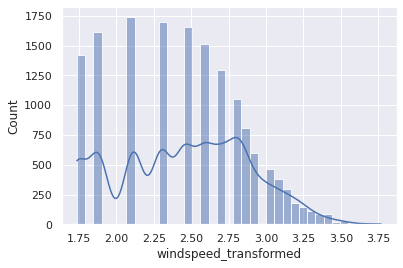

In [160]:
sns.histplot(data=windspeed_train_set, x = "windspeed_transformed", kde=True)

In [161]:
windspeed_train_set.drop(columns=["windspeed"],inplace=True)

In [164]:
windspeed_train_set

,humidity,weather_clear,weather_bad,weather_cloudy,season__1,season__2,season__3,season__4,atemp_1,atemp_2,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,windspeed_transformed
5,0.75,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1.737234
10,0.76,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.697158
11,0.81,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.797856
12,0.77,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.797856
13,0.72,0,1,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2.844006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,0.60,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.300146
17375,0.60,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.300146
17376,0.60,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.300146
17377,0.56,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.114667


Using XGBoost to model the `windspeed`

In [165]:
X_train, X_val = train_test_split(windspeed_train_set, test_size=0.2, shuffle=True, random_state=43)

In [166]:
dtrain = xgb.DMatrix(
    X_train.loc[:, X_train.columns != "windspeed_transformed"], label=X_train["windspeed_transformed"], enable_categorical = True
)
dval = xgb.DMatrix(
    X_val.loc[:, X_val.columns != "windspeed_transformed"], label=X_val["windspeed_transformed"], enable_categorical=True
)

In [167]:
param = {
    "max_depth": 5,
    "eta": 0.03,
    "gamma": 0.09,
    "colsample_bytree": 0.5,
    "objective": "reg:squarederror",
}
num_round = 500
bst = xgb.train(param, dtrain, num_round)

In [168]:
preds = bst.predict(dval)

In [169]:
sklearn.metrics.mean_absolute_error(X_val["windspeed_transformed"], preds)

0.32160089500676836

using this trained model to estimate the box-cox transformed windspeeds of the test set (the 0 values)

In [170]:
windspeed_test_set.drop(columns=["windspeed"],inplace=True)

In [172]:
windspeed_test_set

,humidity,weather_clear,weather_bad,weather_cloudy,season__1,season__2,season__3,season__4,atemp_1,atemp_2,...,month__3,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12
0,0.81,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0.80,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
2,0.80,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
3,0.75,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,0.75,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17319,1.00,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
17320,1.00,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
17322,0.87,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1
17330,0.60,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,1


In [173]:
dtest = xgb.DMatrix(
    windspeed_test_set.loc[:, windspeed_test_set.columns != "windspeed_transformed"], enable_categorical=True
)

In [174]:
preds_test = bst.predict(dtest)

In [175]:
windspeed_test_set["windspeed_transformed"] = preds_test

In [177]:
windspeed_test_set

,humidity,weather_clear,weather_bad,weather_cloudy,season__1,season__2,season__3,season__4,atemp_1,atemp_2,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,windspeed_transformed
0,0.81,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.183253
1,0.80,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.183253
2,0.80,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.183253
3,0.75,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.209244
4,0.75,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.209244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17319,1.00,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.633469
17320,1.00,0,0,1,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.633469
17322,0.87,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.410033
17330,0.60,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.465903


In [178]:
new_df = windspeed_train_set.append(windspeed_test_set)

In [179]:
new_df.sort_index(inplace=True)

In [180]:
new_df

,humidity,weather_clear,weather_bad,weather_cloudy,season__1,season__2,season__3,season__4,atemp_1,atemp_2,...,month__4,month__5,month__6,month__7,month__8,month__9,month__10,month__11,month__12,windspeed_transformed
0,0.81,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.183253
1,0.80,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.183253
2,0.80,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.183253
3,0.75,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.209244
4,0.75,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,2.209244
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,0.60,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.300146
17375,0.60,0,1,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.300146
17376,0.60,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.300146
17377,0.56,1,0,0,1,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,2.114667


In [181]:
pre_processed_train_data = new_df.iloc[:10886,]
windspeed_transformed_train = pre_processed_train_data.windspeed_transformed.values

In [182]:
pre_processed_test_data = new_df.iloc[10886:,]
windspeed_transformed_test = pre_processed_test_data.windspeed_transformed.values

In [183]:
# add these values to the pre-processed dataset before combining
preprocessed_train_data.drop(columns=["windspeed"], inplace=True)
preprocessed_train_data["windspeed_transformed"] = windspeed_transformed_train
preprocessed_train_data.head()

,count,humidity,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,season__1,...,sunday,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,windspeed_transformed
0,16,0.81,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,2.183253
1,40,0.80,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,2.183253
2,32,0.80,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,2.183253
3,13,0.75,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,2.209244
4,1,0.75,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,2.209244


In [184]:
preprocessed_test_data.drop(columns=["windspeed"], inplace=True)
preprocessed_test_data["windspeed_transformed"] = windspeed_transformed_test
preprocessed_test_data.head()

,humidity,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,season__1,season__2,...,sunday,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,windspeed_transformed
0,0.56,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,3.079288
1,0.56,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,2.367040
2,0.56,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,2.367040
3,0.56,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,2.300146
4,0.56,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,2.300146


Now we can normalize the windspeed values using min-max transformation

In [185]:
train_ws_max = preprocessed_train_data.windspeed_transformed.max()
train_ws_min = preprocessed_train_data.windspeed_transformed.min()

In [186]:
normalized_df=(preprocessed_train_data[["windspeed_transformed"]]-train_ws_min)/(train_ws_max-train_ws_min)
preprocessed_train_data.drop(columns=["windspeed_transformed"],inplace=True)
preprocessed_train_data = preprocessed_train_data.join(normalized_df)
preprocessed_train_data.head()

,count,humidity,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,season__1,...,sunday,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,windspeed_transformed
0,16,0.81,1,0,1,0,1,0,0,1,...,0,0,0,0,0,0,0,0,0,0.219418
1,40,0.80,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0.219418
2,32,0.80,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0.219418
3,13,0.75,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0.232204
4,1,0.75,1,0,1,0,1,0,0,1,...,0,1,0,0,0,0,0,0,0,0.232204


In [187]:
normalized_df=(preprocessed_test_data[["windspeed_transformed"]]-train_ws_min)/(train_ws_max-train_ws_min)
preprocessed_test_data.drop(columns=["windspeed_transformed"],inplace=True)
preprocessed_test_data = preprocessed_test_data.join(normalized_df)
preprocessed_test_data.head()

,humidity,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,season__1,season__2,...,sunday,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,windspeed_transformed
0,0.56,1,0,0,1,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0.660219
1,0.56,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.309831
2,0.56,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.309831
3,0.56,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.276923
4,0.56,1,0,0,1,1,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0.276923


Last step remaining is to transform the `count` variable since it is also a skewed variable. 

However we have to keep in mind that the actual predictions to be submitted need to be transformed back.

<AxesSubplot:xlabel='count', ylabel='Count'>

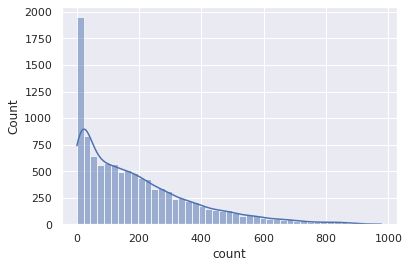

In [188]:
sns.histplot(preprocessed_train_data, x="count", kde=True)

In [189]:
preprocessed_train_data["count_transformed"] = boxcox(preprocessed_train_data['count'].values, lmbda=0.32)

<AxesSubplot:xlabel='count_transformed', ylabel='Count'>

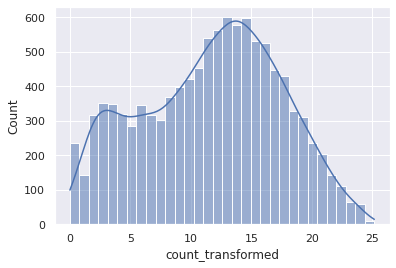

In [190]:
sns.histplot(preprocessed_train_data, x="count_transformed", kde=True)

Count seems to be normally distributed now with these values, so let us run the model to predict these transformed counts, and then do an inverse boxcox transform on the predicted values to get the actual counts back

In [191]:
preprocessed_train_data.drop(columns=["count"], inplace=True)
preprocessed_train_data.head()

,humidity,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,season__1,season__2,...,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,windspeed_transformed,count_transformed
0,0.81,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0.219418,4.463718
1,0.80,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.219418,7.049410
2,0.80,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.219418,6.348229
3,0.75,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.232204,3.975875
4,0.75,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.232204,0.000000


## Step 5: Rerun the model with the same settings as before, just with more features

Run the model again on the new datasets

In [192]:
predictor = TabularPredictor(label="count_transformed", eval_metric="root_mean_squared_error").fit(preprocessed_train_data, 
                                                                                       time_limit=1200, 
                                                                                       presets="best_quality", 
                                                                                       auto_stack=True, 
                                                                                       num_bag_folds=5,
                                                                                       num_bag_sets=2,
                                                                                       num_stack_levels=3
                                                                                      )

No path specified. Models will be saved in: "AutogluonModels/ag-20221025_030847/"
Presets specified: ['best_quality']
Stack configuration (auto_stack=True): num_stack_levels=3, num_bag_folds=5, num_bag_sets=2
Beginning AutoGluon training ... Time limit = 1200s
AutoGluon will save models to "AutogluonModels/ag-20221025_030847/"
AutoGluon Version:  0.5.2
Python Version:     3.7.10
Operating System:   Linux
Train Data Rows:    10886
Train Data Columns: 44
Label Column: count_transformed
Preprocessing data ...
AutoGluon infers your prediction problem is: 'regression' (because dtype of label-column == float and many unique label-values observed).
	Label info (max, min, mean, stddev): (25.16391443532209, 0.0, 11.65516, 5.73301)
	If 'regression' is not the correct problem_type, please manually specify the problem_type parameter during predictor init (You may specify problem_type as one of: ['binary', 'multiclass', 'regression'])
Using Feature Generators to preprocess the data ...
Fitting Auto

In [193]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -1.709967       5.543761  479.201571                0.000749           0.535699            3       True         22
1     ExtraTreesMSE_BAG_L2  -1.716013       3.671685  293.250168                0.702600          15.511165            2       True         17
2      WeightedEnsemble_L4  -1.719143       7.558237  671.496551                0.000841           0.545253            4       True         32
3          CatBoost_BAG_L3  -1.726740       5.987127  593.862323                0.064462          17.888313            3       True         26
4      WeightedEnsemble_L5  -1.729316      10.520802  991.985767                0.001301           0.611000            5       True         42
5          LightGBM_BAG_L3  -1.730860       6.009135  588.421698                

{'model_types': {'KNeighborsUnif_BAG_L1': 'StackerEnsembleModel_KNN',
  'KNeighborsDist_BAG_L1': 'StackerEnsembleModel_KNN',
  'LightGBMXT_BAG_L1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L1': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L1': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L1': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L1': 'StackerEnsembleModel_NNFastAiTabular',
  'XGBoost_BAG_L1': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'LightGBMLarge_BAG_L1': 'StackerEnsembleModel_LGB',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBMXT_BAG_L2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2': 'StackerEnsembleModel_LGB',
  'RandomForestMSE_BAG_L2': 'StackerEnsembleModel_RF',
  'CatBoost_BAG_L2': 'StackerEnsembleModel_CatBoost',
  'ExtraTreesMSE_BAG_L2': 'StackerEnsembleModel_XT',
  'NeuralNetFastAI_BAG_L2': 'StackerEnsembleModel_NNFa

In [194]:
predictor.leaderboard()

                     model  score_val  pred_time_val    fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0      WeightedEnsemble_L3  -1.709967       5.543761  479.201571                0.000749           0.535699            3       True         22
1     ExtraTreesMSE_BAG_L2  -1.716013       3.671685  293.250168                0.702600          15.511165            2       True         17
2      WeightedEnsemble_L4  -1.719143       7.558237  671.496551                0.000841           0.545253            4       True         32
3          CatBoost_BAG_L3  -1.726740       5.987127  593.862323                0.064462          17.888313            3       True         26
4      WeightedEnsemble_L5  -1.729316      10.520802  991.985767                0.001301           0.611000            5       True         42
5          LightGBM_BAG_L3  -1.730860       6.009135  588.421698                0.086470          12.447689            3       True         24

,model,score_val,pred_time_val,fit_time,pred_time_val_marginal,fit_time_marginal,stack_level,can_infer,fit_order
0,WeightedEnsemble_L3,-1.709967,5.543761,479.201571,0.000749,0.535699,3,True,22
1,ExtraTreesMSE_BAG_L2,-1.716013,3.671685,293.250168,0.702600,15.511165,2,True,17
2,WeightedEnsemble_L4,-1.719143,7.558237,671.496551,0.000841,0.545253,4,True,32
3,CatBoost_BAG_L3,-1.726740,5.987127,593.862323,0.064462,17.888313,3,True,26
4,WeightedEnsemble_L5,-1.729316,10.520802,991.985767,0.001301,0.611000,5,True,42
5,LightGBM_BAG_L3,-1.730860,6.009135,588.421698,0.086470,12.447689,3,True,24
6,CatBoost_BAG_L4,-1.732903,8.663546,851.421007,0.055093,16.833139,4,True,36
7,RandomForestMSE_BAG_L2,-1.734991,3.786224,317.101645,0.817139,39.362643,2,True,15
8,ExtraTreesMSE_BAG_L3,-1.740521,6.575164,590.926323,0.652499,14.952313,3,True,27
9,XGBoost_BAG_L3,-1.740927,6.012204,589.313933,0.089540,13.339923,3,True,29


In [195]:
predictor.evaluate(preprocessed_train_data)

Evaluation: root_mean_squared_error on test data: -1.678828251114754
	Note: Scores are always higher_is_better. This metric score can be multiplied by -1 to get the metric value.
Evaluations on test data:
{
    "root_mean_squared_error": -1.678828251114754,
    "mean_squared_error": -2.818464296741024,
    "mean_absolute_error": -1.2709445158856278,
    "r2": 0.9142395487039373,
    "pearsonr": 0.956160230472608,
    "median_absolute_error": -0.966761520482426
}


{'root_mean_squared_error': -1.678828251114754,
 'mean_squared_error': -2.818464296741024,
 'mean_absolute_error': -1.2709445158856278,
 'r2': 0.9142395487039373,
 'pearsonr': 0.956160230472608,
 'median_absolute_error': -0.966761520482426}

In [201]:
train_preds = predictor.predict(preprocessed_train_data.iloc[:,:-1])
train_preds = inv_boxcox(train_preds, 0.32)
train_preds_log = np.log(train_preds+1)
train_counts_log = np.log(preprocessed_train_data.count_transformed+1)
train_errors = (np.sqrt(abs(train_counts_log - train_preds_log))).mean()
print(f"training_RMSLE: {train_errors}")

training_RMSLE: 1.4637948842502102


In [202]:
predictions = predictor.predict(preprocessed_test_data)
predictions.head()

0    4.059525
1    0.788865
2    0.788865
3    0.834664
4    0.834664
Name: count_transformed, dtype: float32

In [203]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean       11.588725
std         5.427245
min         0.606701
25%         7.345763
50%        12.132465
75%        15.781278
max        22.973425
Name: count_transformed, dtype: float64

# Let us do the inverse box cox to get the actual `count` values

In [204]:
predictions_final = inv_boxcox(predictions, 0.32)

In [205]:
predictions_final.describe()

count    6493.000000
mean      183.061798
std       166.037354
min         1.741015
25%        43.754826
50%       141.897964
75%       277.324066
max       759.474854
Name: count_transformed, dtype: float64

In [206]:
# How many negative values do we have?
predictions_final[predictions_final<0]

Series([], Name: count_transformed, dtype: float32)

In [207]:
submission["count"] = predictions_final
submission.to_csv("submission.csv", index=False)

In [208]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "FeatEng with wind,count transformations no hyperopt"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 409kB/s]
Successfully submitted to Bike Sharing Demand

In [209]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 10

fileName        date                 description                                          status    publicScore  privateScore  
--------------  -------------------  ---------------------------------------------------  --------  -----------  ------------  
submission.csv  2022-10-25 03:33:32  FeatEng with wind,count transformations no hyperopt  complete  0.52900      0.52900       
submission.csv  2022-10-25 02:52:44  first raw submission                                 complete  1.76328      1.76328       
submission.csv  2022-10-25 02:20:30  first raw submission                                 complete  1.79318      1.79318       
submission.csv  2022-10-25 01:08:27  new feats hpo log count                              complete  0.51762      0.51762       
submission.csv  2022-10-25 01:07:45  new feats hpo log count                              complete  0.83696      0.83696       
submission.csv  2022-10-25 00:43:35  new feats hpo rf                                     complete  0.83

#### New Score of `0.529`

## Step 6: Hyper parameter optimization
* There are many options for hyper parameter optimization.
* Options are to change the AutoGluon higher level parameters or the individual model hyperparameters.
* The hyperparameters of the models themselves that are in AutoGluon. Those need the `hyperparameter` and `hyperparameter_tune_kwargs` arguments.

In [210]:
# import different models from autogluon 
from autogluon.tabular.models import LGBModel, CatBoostModel, XGBoostModel, RFModel, XTModel, TabularNeuralNetTorchModel, TabularNeuralNetMxnetModel, NNFastAiTabularModel
import autogluon.core as ag

In [211]:
lgbm = LGBModel()
catbm = CatBoostModel()
xgb = XGBoostModel()
rf = RFModel()
xt = XTModel()
nn_torch = TabularNeuralNetTorchModel()
nn_mxnet = TabularNeuralNetMxnetModel()
nn_fastai = NNFastAiTabularModel()

No path specified. Models will be saved in: "AutogluonModels/ag-20221025_033340/LGBModel/"
No path specified. Models will be saved in: "AutogluonModels/ag-20221025_033340/CatBoostModel/"
No path specified. Models will be saved in: "AutogluonModels/ag-20221025_033340/XGBoostModel/"
No path specified. Models will be saved in: "AutogluonModels/ag-20221025_033340/RFModel/"
No path specified. Models will be saved in: "AutogluonModels/ag-20221025_033340/XTModel/"
No path specified. Models will be saved in: "AutogluonModels/ag-20221025_033340/TabularNeuralNetTorchModel/"
No path specified. Models will be saved in: "AutogluonModels/ag-20221025_033340/TabularNeuralNetMxnetModel/"
No path specified. Models will be saved in: "AutogluonModels/ag-20221025_033340/NNFastAiTabularModel/"


In [212]:
nn_options = {  # specifies non-default hyperparameter values for neural network models
    'num_epochs': 50,  # number of training epochs (controls training time of NN models)
    'learning_rate': ag.space.Real(3e-4, 1e-2, log=True),  # learning rate used in training (real-valued hyperparameter searched on log-scale)
    'activation': ag.space.Categorical('relu', 'tanh'),  # activation function used in NN (categorical hyperparameter, default = first entry)
    'dropout_prob': ag.space.Real(0.0, 0.5, default=0.1),  # dropout probability (real-valued hyperparameter)
}

In [213]:
gbm_options = {  # specifies non-default hyperparameter values for lightGBM gradient boosted trees
    'learning_rate': ag.Real(3e-4, 0.3, log=True),
    'num_boost_round': 1000,  # number of boosting rounds (controls training time of GBM models)
    'num_leaves': ag.space.Int(lower=26, upper=66, default=36),  # number of leaves in trees (integer hyperparameter)
    'max_depth': ag.space.Int(lower=3, upper=10, default=6)
}

In [214]:
xgbm_options = { # specifies non-default hyperparameter values for XGBoost gradient boosted trees
                'n_estimators': 1000,
                'learning_rate': ag.space.Real(1e-4, 3e-1, default=2e-2, log=True),
                'colsample_bytree': ag.space.Real(1e-4, 1, default=5e-2, log=True),
                'lambda': ag.space.Real(1e-4, 1, default=5e-2, log=True)
               }

In [215]:
## Keys for the model types
# 'GBM': Light GBM,
# 'CAT': CatBoost,
# 'XGB': XGBoost,
# 'RF': Random Forest,
# 'XT': Extra Trees,
# 'NN_TORCH': PyTorch Neural Net,
# 'NN_MXNET': MXNet Neural Net,
# 'FASTAI': FastAI Neural Net


hyperparameters = {  # hyperparameters of each model type
                   'NN_TORCH': nn_options,
                   'GBM': gbm_options,
                   'XGB': xgbm_options,
                   
                  }

# Custom stack ensembling
# hyperparameters = {
#     1: {'GBM': gbm_options}, 
#     2: {'XGB': [xgbm_options], 'NN_TORCH': nn_options},
#     3: {"RF": {}}
# }

In [216]:
hyperparameter_tune_kwargs = {  # HPO is not performed unless hyperparameter_tune_kwargs is specified
    'num_trials': 5,
    'scheduler' : "local",
    'searcher': "auto"
}

In [217]:
predictor = TabularPredictor(label="count_transformed", eval_metric="root_mean_squared_error").fit(preprocessed_train_data, 
                                                                                       time_limit=1200, 
                                                                                       presets="best_quality", 
                                                                                       auto_stack=True, 
                                                                                       num_bag_folds=5,
                                                                                       num_bag_sets=2,
                                                                                       num_stack_levels=3,
                                                                                       hyperparameters=hyperparameters,
                                                                                       hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                                       verbosity=0
                                                                                      )

No path specified. Models will be saved in: "AutogluonModels/ag-20221025_033348/"
  0%|          | 0/5 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 4.74657


 60%|██████    | 3/5 [00:05<00:03,  1.75s/it]

[1000]	valid_set's rmse: 2.89128


 80%|████████  | 4/5 [00:06<00:01,  1.58s/it]

[1000]	valid_set's rmse: 1.7995


100%|██████████| 5/5 [00:06<00:00,  1.34s/it]
2022-10-25 03:34:09,242	ERROR syncer.py:147 -- Log sync requires rsync to be installed.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
  0%|          | 0/5 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 4.4008


 60%|██████    | 3/5 [00:06<00:04,  2.00s/it]

[1000]	valid_set's rmse: 1.9525


100%|██████████| 5/5 [00:11<00:00,  2.22s/it]
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
  0%|          | 0/5 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 4.41347


 60%|██████    | 3/5 [00:06<00:03,  2.00s/it]

[1000]	valid_set's rmse: 1.97423


100%|██████████| 5/5 [00:09<00:00,  1.97s/it]
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
  0%|          | 0/5 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 4.45331


 40%|████      | 2/5 [00:06<00:10,  3.39s/it]
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


In [218]:
predictor.fit_summary()

*** Summary of fit() ***
Estimated performance of each model:
                       model  score_val  pred_time_val     fit_time  pred_time_val_marginal  fit_time_marginal  stack_level  can_infer  fit_order
0        WeightedEnsemble_L3  -1.778244       7.022648   548.568486                0.001141           0.810898            3       True         26
1          XGBoost_BAG_L2/T3  -1.783042       6.390866   360.259035                0.285622          15.316813            2       True         21
2         LightGBM_BAG_L2/T3  -1.784718       6.249691   356.277861                0.144447          11.335639            2       True         16
3        WeightedEnsemble_L2  -1.784973       3.070834   264.599079                0.000950           0.698275            2       True         13
4        WeightedEnsemble_L4  -1.786558      11.019505   821.598609                0.001134           1.085356            4       True         39
5          XGBoost_BAG_L3/T3  -1.787126      10.458254   664.0

{'model_types': {'LightGBM_BAG_L1/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L1/T5': 'StackerEnsembleModel_LGB',
  'XGBoost_BAG_L1/T1': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T2': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T3': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T4': 'StackerEnsembleModel_XGBoost',
  'XGBoost_BAG_L1/T5': 'StackerEnsembleModel_XGBoost',
  'NeuralNetTorch_BAG_L1/T1': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'NeuralNetTorch_BAG_L1/T2': 'StackerEnsembleModel_TabularNeuralNetTorch',
  'WeightedEnsemble_L2': 'WeightedEnsembleModel',
  'LightGBM_BAG_L2/T1': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T2': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T3': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T4': 'StackerEnsembleModel_LGB',
  'LightGBM_BAG_L2/T5': 'StackerEnsemble

In [219]:
train_preds = predictor.predict(preprocessed_train_data.iloc[:,:-1])
train_preds = inv_boxcox(train_preds, 0.32)
train_preds_log = np.log(train_preds+1)
train_counts_log = np.log(preprocessed_train_data.count_transformed+1)
train_errors = (np.sqrt(abs(train_counts_log - train_preds_log))).mean()
print(f"training_RMSLE: {train_errors}")

training_RMSLE: 1.4667059728437757


In [220]:
predictor.evaluate(preprocessed_train_data)

{'root_mean_squared_error': -1.6096360875224123,
 'mean_squared_error': -2.590928334254459,
 'mean_absolute_error': -1.2651303562164757,
 'r2': 0.9211630307049317,
 'pearsonr': 0.9598795144791916,
 'median_absolute_error': -1.0393269842290125}

In [221]:
predictions = predictor.predict(preprocessed_test_data)
predictions.head()

0    3.903300
1    1.349719
2    1.349719
3    1.351036
4    1.351036
Name: count_transformed, dtype: float32

In [222]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean       11.590753
std         5.398349
min         1.224947
25%         7.556004
50%        12.249469
75%        15.754378
max        22.228214
Name: count_transformed, dtype: float64

In [223]:
predictions_final = inv_boxcox(predictions, 0.32)

In [224]:
predictions_final.describe()

count    6493.000000
mean      182.379761
std       163.481476
min         2.810969
25%        46.559299
50%       145.326248
75%       276.092896
max       693.740295
Name: count_transformed, dtype: float64

In [225]:
submission["count"] = predictions_final
submission.to_csv("submission.csv", index=False)

In [226]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "new features with hyperparameters new stack"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 365kB/s]
Successfully submitted to Bike Sharing Demand

In [227]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 100

fileName        date                 description                                          status    publicScore  privateScore  
--------------  -------------------  ---------------------------------------------------  --------  -----------  ------------  
submission.csv  2022-10-25 03:54:35  new features with hyperparameters new stack          complete  0.52384      0.52384       
submission.csv  2022-10-25 03:33:32  FeatEng with wind,count transformations no hyperopt  complete  0.52900      0.52900       
submission.csv  2022-10-25 02:52:44  first raw submission                                 complete  1.76328      1.76328       
submission.csv  2022-10-25 02:20:30  first raw submission                                 complete  1.79318      1.79318       
submission.csv  2022-10-25 01:08:27  new feats hpo log count                              complete  0.51762      0.51762       
submission.csv  2022-10-25 01:07:45  new feats hpo log count                              complete  0.83

#### New Score of `0.52538 `

# A Different Approach: `ln(count+1)`

Since the `count` variable is highly skewed, and the validation metric used on Kaggle is `RMSLE (Root Mean Squared Log Error)`, it makes sense that we train our models on the natural log of the count variable `ln(count + 1)`. This will allow the models to calculate the RMSE on the logs of the actual and predicted values, effectively allowing us to model on the metric of `RMSLE`.

First let us get rid of the BCT'd `count` values and replace it with the `ln(count + 1)` values. There is a `+1` here as there are some count values which are 0, and `ln` requires all positive values.

This is fine however as it won't affect our metrics too much. RMSLE has a lower penalty for overestimated values, and a large penalty for underestimated values.

In [242]:
original_count_values = train['count'].values

In [243]:
log_count = np.log(original_count_values+1)

In [244]:
preprocessed_train_data.head()

,humidity,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,season__1,season__2,...,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,windspeed_transformed,count_transformed
0,0.81,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0.219418,2.833213
1,0.80,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.219418,3.713572
2,0.80,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.219418,3.496508
3,0.75,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.232204,2.639057
4,0.75,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.232204,0.693147


In [245]:
# replace the count values with these new log count values
preprocessed_train_data.count_transformed = log_count
preprocessed_train_data.head()

,humidity,holiday__0,holiday__1,workingday__0,workingday__1,weather_clear,weather_bad,weather_cloudy,season__1,season__2,...,time_0,time_1,time_2,time_3,time_4,time_5,time_6,time_7,windspeed_transformed,count_transformed
0,0.81,1,0,1,0,1,0,0,1,0,...,0,0,0,0,0,0,0,0,0.219418,2.833213
1,0.80,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.219418,3.713572
2,0.80,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.219418,3.496508
3,0.75,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.232204,2.639057
4,0.75,1,0,1,0,1,0,0,1,0,...,1,0,0,0,0,0,0,0,0.232204,0.693147


In [246]:
predictor = TabularPredictor(label="count_transformed", eval_metric="root_mean_squared_error").fit(preprocessed_train_data, 
                                                                                       time_limit=1200, 
                                                                                       presets="best_quality", 
                                                                                       auto_stack=True, 
                                                                                       num_bag_folds=5,
                                                                                       num_bag_sets=2,
                                                                                       num_stack_levels=3,
                                                                                       hyperparameters=hyperparameters,
                                                                                       hyperparameter_tune_kwargs=hyperparameter_tune_kwargs,
                                                                                       verbosity=0
                                                                                      )

No path specified. Models will be saved in: "AutogluonModels/ag-20221025_043224/"
  0%|          | 0/5 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 1.15061


 60%|██████    | 3/5 [00:05<00:03,  1.71s/it]

[1000]	valid_set's rmse: 0.676333


 80%|████████  | 4/5 [00:06<00:01,  1.58s/it]

[1000]	valid_set's rmse: 0.471268


100%|██████████| 5/5 [00:06<00:00,  1.33s/it]
NaN or Inf found in input tensor.
2022-10-25 04:33:03,722	INFO stopper.py:364 -- Reached timeout of 19.19292210053158 seconds. Stopping all trials.
  0%|          | 0/5 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 1.07629


 60%|██████    | 3/5 [00:07<00:04,  2.04s/it]

[1000]	valid_set's rmse: 0.491639


100%|██████████| 5/5 [00:10<00:00,  2.16s/it]
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
  0%|          | 0/5 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 1.10139


 60%|██████    | 3/5 [00:07<00:04,  2.20s/it]

[1000]	valid_set's rmse: 0.502794


100%|██████████| 5/5 [00:10<00:00,  2.11s/it]
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
  0%|          | 0/5 [00:00<?, ?it/s]

[1000]	valid_set's rmse: 1.10596


 40%|████      | 2/5 [00:06<00:10,  3.40s/it]
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.
NaN or Inf found in input tensor.


In [247]:
# predictions and target are both log values
train_preds_log = predictor.predict(preprocessed_train_data.iloc[:,:-1])
train_counts_log = preprocessed_train_data.count_transformed

train_errors = (np.sqrt(abs(train_counts_log - train_preds_log))).mean()
print(f"training_RMSLE: {train_errors}")

training_RMSLE: 0.4978055474901413


In [248]:
predictor.evaluate(preprocessed_train_data)

{'root_mean_squared_error': -0.41923692799495166,
 'mean_squared_error': -0.17575960179464428,
 'mean_absolute_error': -0.3063047142841683,
 'r2': 0.9127598913619348,
 'pearsonr': 0.9555067207868448,
 'median_absolute_error': -0.22347962752124984}

In [249]:
predictions = predictor.predict(preprocessed_test_data)
predictions.head()

0    2.549858
1    1.355424
2    1.355424
3    1.354181
4    1.354181
Name: count_transformed, dtype: float32

In [250]:
# Describe the `predictions` series to see if there are any negative values
predictions.describe()

count    6493.000000
mean        4.581038
std         1.329285
min         1.250084
25%         3.795995
50%         4.954998
75%         5.622943
max         6.459423
Name: count_transformed, dtype: float64

Get the actual predictions back by taking the exponent and subtracting 1

In [251]:
predictions_final = np.exp(predictions) - 1

In [252]:
predictions_final.describe()

count    6493.000000
mean      178.648010
std       158.985306
min         2.490637
25%        43.522503
50%       140.882385
75%       275.702637
max       637.692444
Name: count_transformed, dtype: float64

In [253]:
submission["count"] = predictions_final
submission.to_csv("submission.csv", index=False)

In [254]:
!kaggle competitions submit -c bike-sharing-demand -f submission.csv -m "new feats hpo log count"

100%|█████████████████████████████████████████| 188k/188k [00:00<00:00, 330kB/s]
Successfully submitted to Bike Sharing Demand

In [258]:
!kaggle competitions submissions -c bike-sharing-demand | tail -n +1 | head -n 7

fileName        date                 description                                          status    publicScore  privateScore  
--------------  -------------------  ---------------------------------------------------  --------  -----------  ------------  
submission.csv  2022-10-25 04:53:19  new feats hpo log count                              complete  0.51749      0.51749       
submission.csv  2022-10-25 04:24:57  new feats hpo log count                              complete  0.52761      0.52761       
submission.csv  2022-10-25 03:54:35  new features with hyperparameters new stack          complete  0.52384      0.52384       
submission.csv  2022-10-25 03:33:32  FeatEng with wind,count transformations no hyperopt  complete  0.52900      0.52900       
submission.csv  2022-10-25 02:52:44  first raw submission                                 complete  1.76328      1.76328       
tail: write error: Broken pipe


### That seemed to have worked quite well, the new score is `0.517`

## Step 7: Write a Report
### Refer to the markdown file for the full report
### Creating plots and table for report

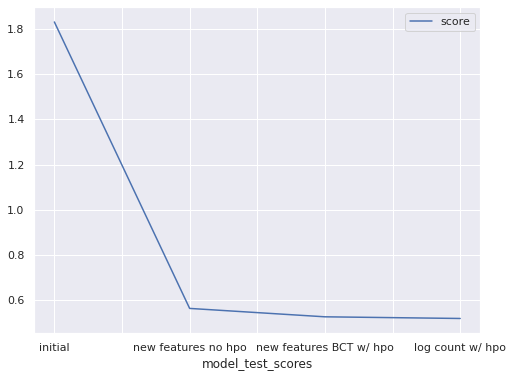

In [264]:
# Taking the top model score from each training run and creating a line plot to show improvement
# You can create these in the notebook and save them to PNG or use some other tool (e.g. google sheets, excel)
fig = pd.DataFrame(
    {
        "model_test_scores": ["initial", "new features no hpo", "new features BCT w/ hpo", "log count w/ hpo"],
        "score": [1.832, 0.56222, 0.525, 0.51762]
    }
).plot(x="model_test_scores", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_train_score.png')

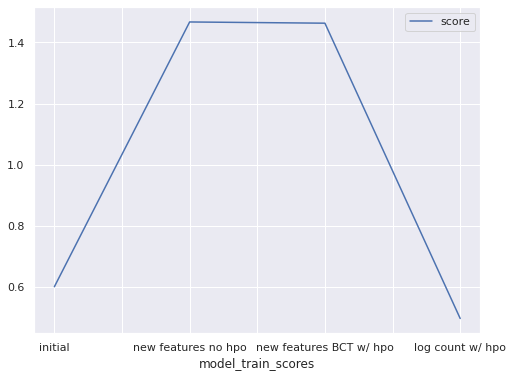

In [266]:
# Take the 3 kaggle scores and creating a line plot to show improvement
fig = pd.DataFrame(
    {
        "model_train_scores": ["initial", "new features no hpo", "new features BCT w/ hpo", "log count w/ hpo"],
        "score": [0.602, 1.467, 1.463, 0.4983]
    }
).plot(x="model_train_scores", y="score", figsize=(8, 6)).get_figure()
fig.savefig('model_test_score.png')